# **Clustering using KMeans, Agglomerative, and Birch Clustering**

In [2]:
# Import Package yang dibutuhkan
import numpy as np 
import pandas as pd 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, Birch, MeanShift, KMeans, DBSCAN, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors

In [3]:
df = pd.read_csv('data.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# Ukuran dataset
df.shape

(2240, 29)

In [4]:
# Mengecek null value
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Hanya ada sedikit data yang null, maka bisa kita drop

In [5]:
df.dropna(inplace=True)

In [6]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

## **Feature Engineering**

Kolom Education

In [7]:
df['Education'].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [8]:
# Kita sederhanakan menjadi 3 kategori, yaitu undergraduate, graduate, dan postgraduate
df['Education'] = df['Education'].replace({'Basic':'Undergraduate', '2n Cycle':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

Kolom Marital Status

In [9]:
df['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [10]:
# Kita sederhanakan menjadi 2 kategori, yaitu single dan not single
df['Marital_Status'] = df['Marital_Status'].replace({'YOLO':'Single', 'Alone':'Single', 'Absurd':'Single', 'Widow':'Single', 'Divorced':'Single', 'Together':'Not Single', 'Married':'Not Single'})

Kolom Dt_Customer

In [11]:
df['Dt_Customer'].value_counts()

31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
09-05-2014     1
26-06-2013     1
09-01-2014     1
Name: Dt_Customer, Length: 662, dtype: int64

In [12]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

C:\Users\Nando\AppData\Local\Temp\ipykernel_16688\177162232.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])


Membuat kolom yang merepresentasikan seberapa lama seseorang sudah menjadi pengguna produk ini

In [13]:
df['days_since_registration'] = (datetime.today() - df['Dt_Customer']).dt.days

In [14]:
df.drop(columns=['Dt_Customer'], inplace=True)

Membuat kolom Age berdasarkan tahun lahir seseorang

In [15]:
df['Age'] = 2023 - df['Year_Birth']

In [16]:
df.drop(['Year_Birth'], axis=1, inplace=True)

Membuat kolom Total_Children berdasarkan jumlah anak dari kolom Kidhome dan Teenhome

In [17]:
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

In [18]:
df.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)

In [19]:
# df['Parent'] = df['Total_Children'].apply(lambda x: 1 if x > 0 else 0)

Membuat kolom Total_Spent yang merepresentasikan jumlah uang yang dihabiskan oleh seseorang

In [20]:
df['Total_Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

Membuat kolom Total_Purchase yang merepresentasikan jumlah produk yang dibeli oleh seseorang

In [21]:
df['Total_Purchase'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

Membuang kolom yang isinya sama semua dan 100% unique

In [22]:
df['Z_CostContact'].value_counts()

3    2216
Name: Z_CostContact, dtype: int64

In [23]:
df['Z_Revenue'].value_counts()

11    2216
Name: Z_Revenue, dtype: int64

In [24]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

In [25]:
df.drop(['ID'], axis=1, inplace=True)

Hapus kolom yang tidak diperlukan

In [26]:
delete_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']
df = df.drop(delete_cols, axis=1)

In [27]:
df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,days_since_registration,Age,Total_Children,Total_Spent,Total_Purchase
0,Graduate,Single,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,4119,66,0,1617,25
1,Graduate,Single,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,3273,69,2,27,6
2,Graduate,Not Single,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,3620,58,0,776,21
3,Graduate,Not Single,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,3213,39,1,53,8
4,Postgraduate,Not Single,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,3469,42,1,422,19


Membuang Outlier

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

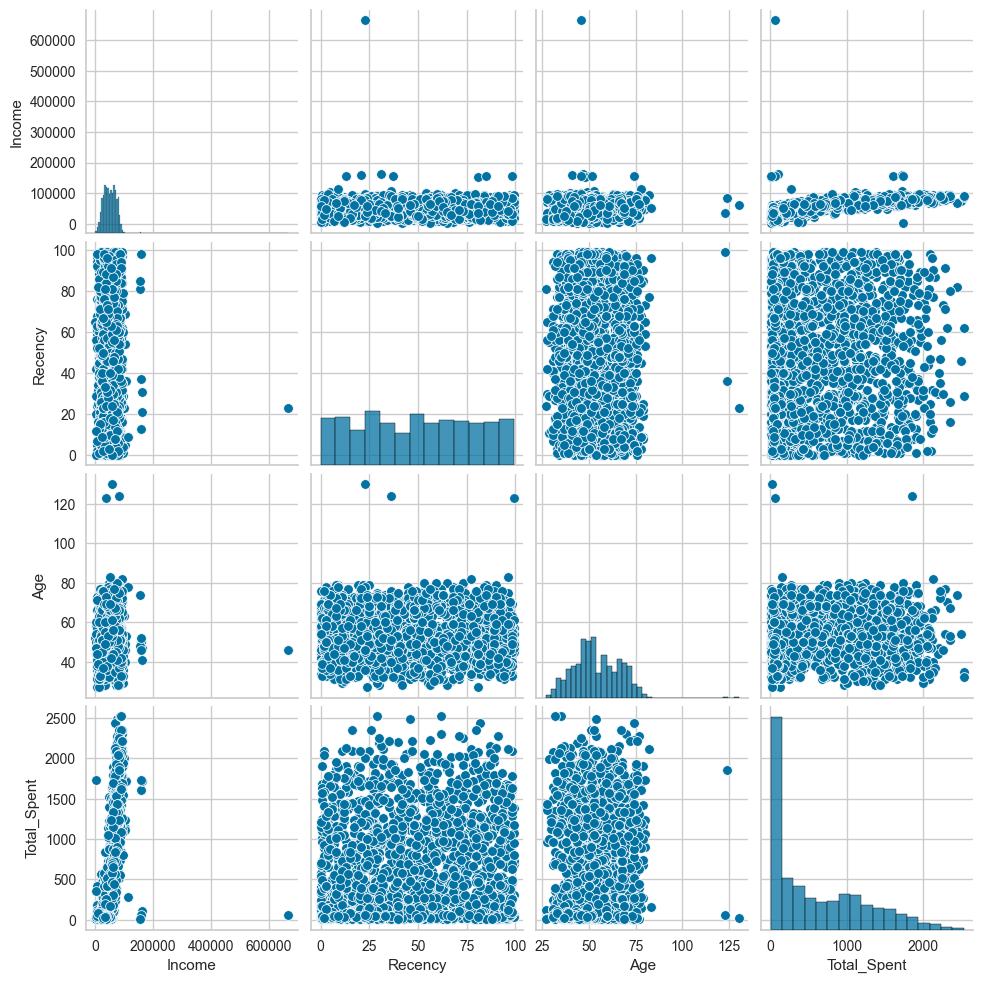

In [28]:
plot = ["Income", "Recency", "Age", "Total_Spent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[plot])
plt.show()

Tampak ada outlier pada kolom Income dan Age

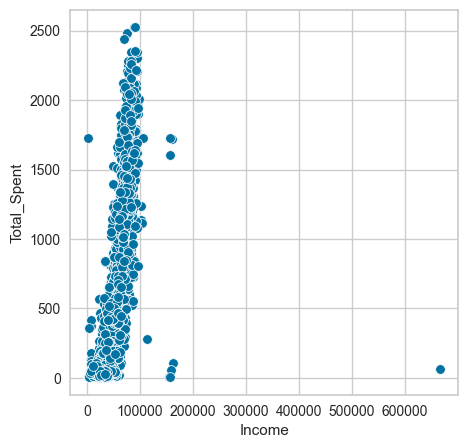

In [29]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Income', y='Total_Spent', data=df)
plt.show()

Ada outlier pada kolom Income

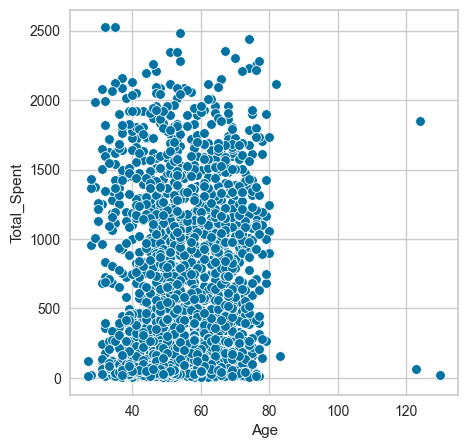

In [30]:
# scatterplot
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Age', y='Total_Spent', data=df)
plt.show()

Ada outlier pada kolom Age

Membuang outlier tersebut

In [31]:
df = df[df['Age'] < 100]
df = df[df['Income'] < 150000]

## **Data Preprocessing**
Encode kolom yang memiliki tipe data object

In [32]:
encode = ['Education', 'Marital_Status']

In [33]:
le = LabelEncoder()

for item in encode:
    df[item] = le.fit_transform(df[item])

## **Model Clustering**
### **KMeans Clustering**

Elbow Method untuk mencari jumlah cluster optimal:


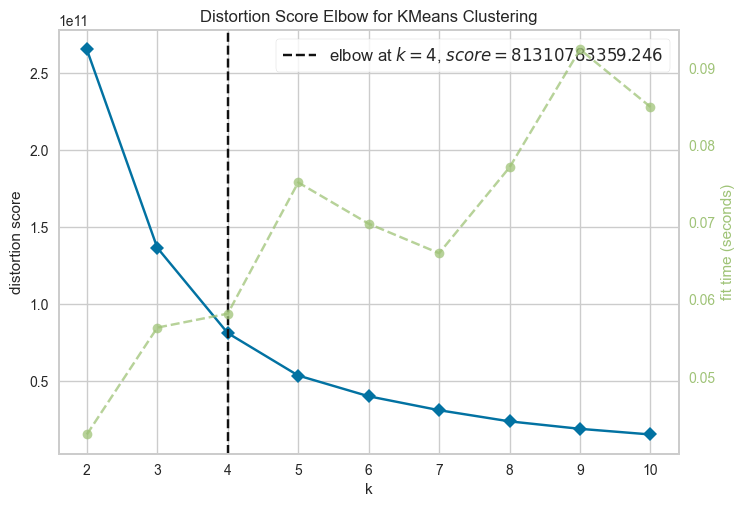

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [283]:
# Mencari jumlah cluster paling optimal untuk KMeans
print('Elbow Method untuk mencari jumlah cluster optimal:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df)
Elbow_M.show()

Artinya, 4 cluster adalah jumlah cluster paling optimal untuk KMeans

In [34]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df)

KMeans(n_clusters=4, random_state=0)

In [286]:
with open('models/kmeans.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [35]:
kmeans = kmeans.predict(df)
df['Cluster'] = kmeans

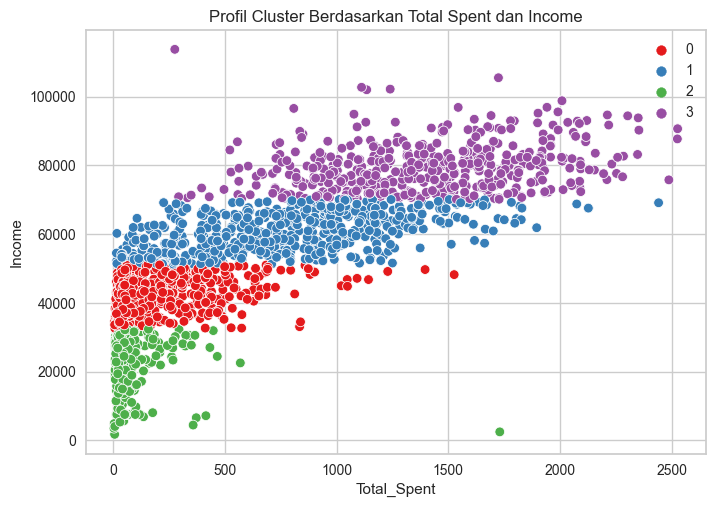

In [112]:
pl = sns.scatterplot(data = df,x=df["Total_Spent"], y=df["Income"],hue=df["Cluster"], palette="Set1")
pl.set_title("Profil Cluster Berdasarkan Total Spent dan Income")
plt.legend()
plt.show()

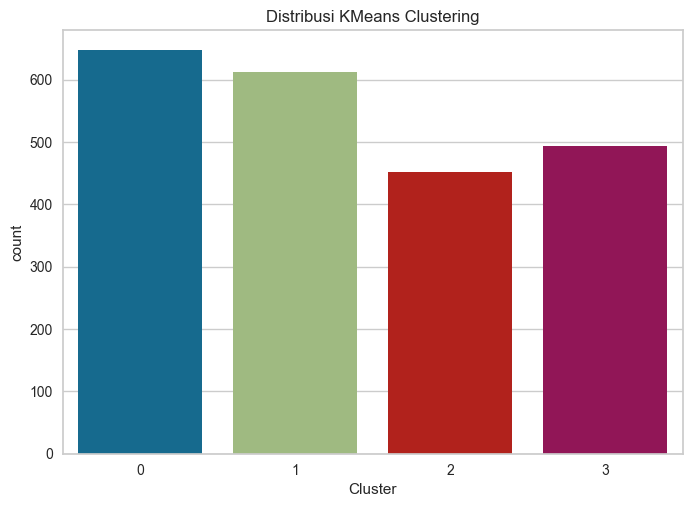

In [113]:
pl = sns.countplot(x=df["Cluster"])
pl.set_title("Distribusi KMeans Clustering")
plt.show()

c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  

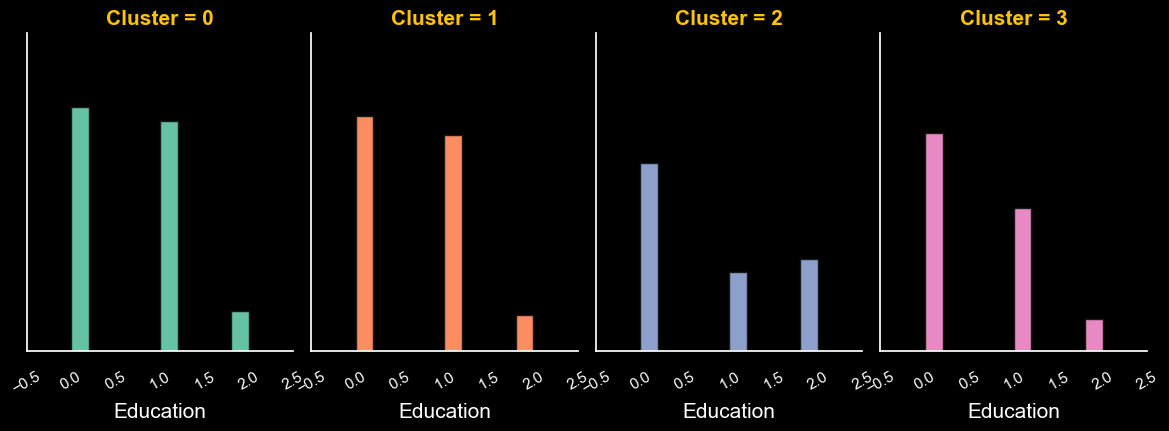

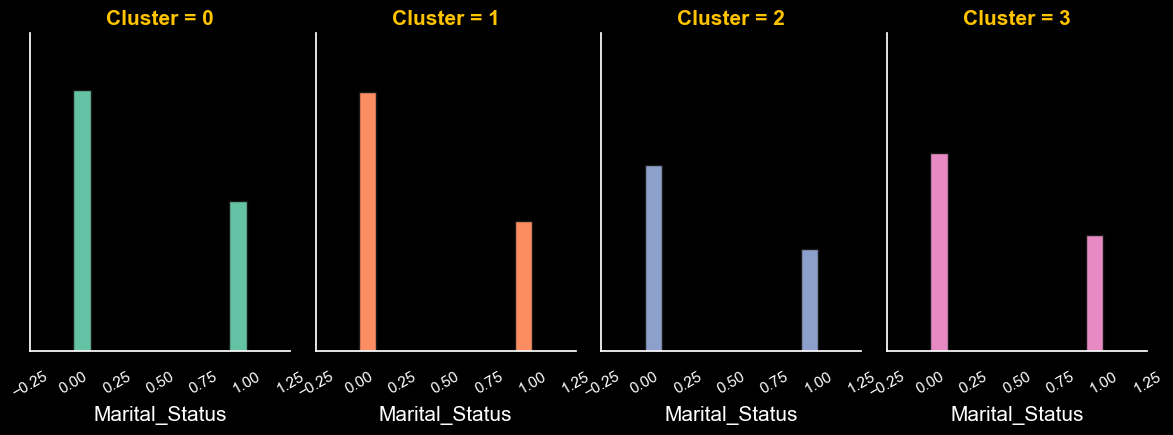

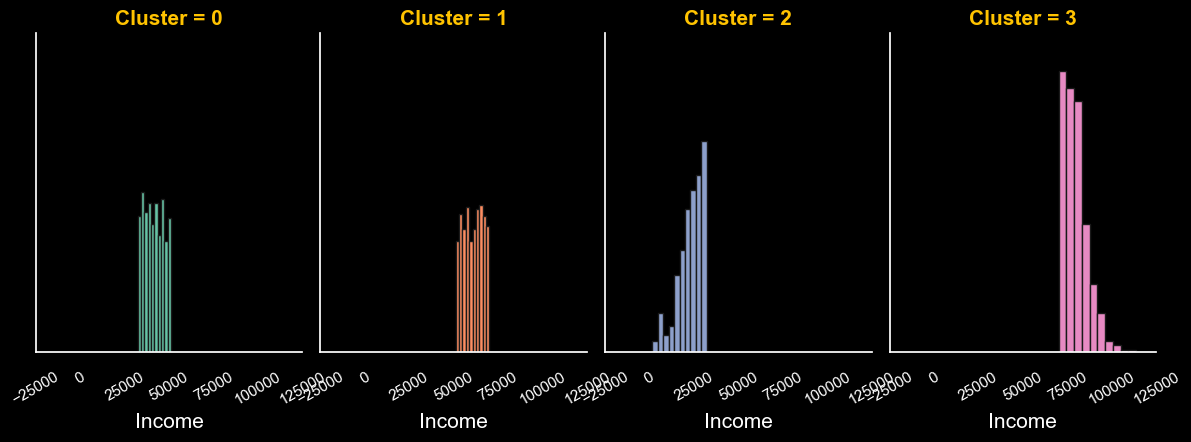

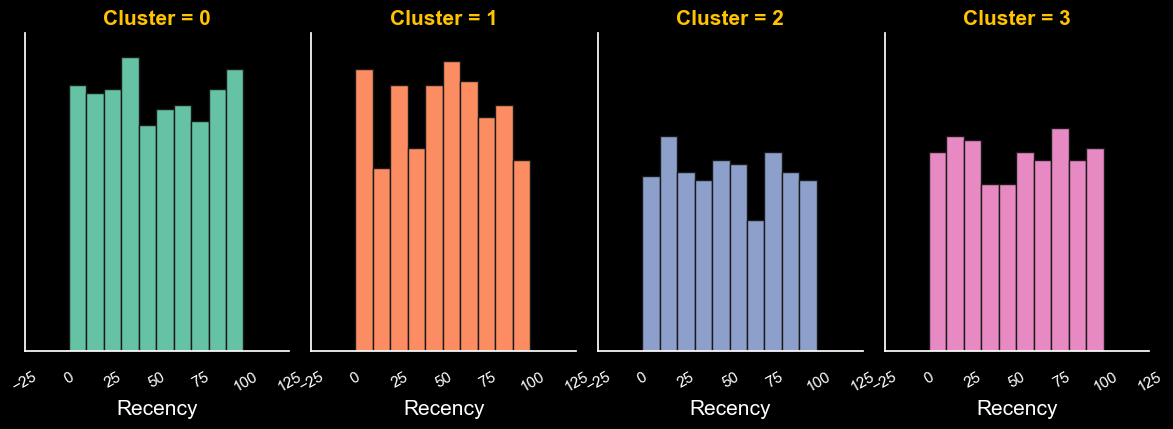

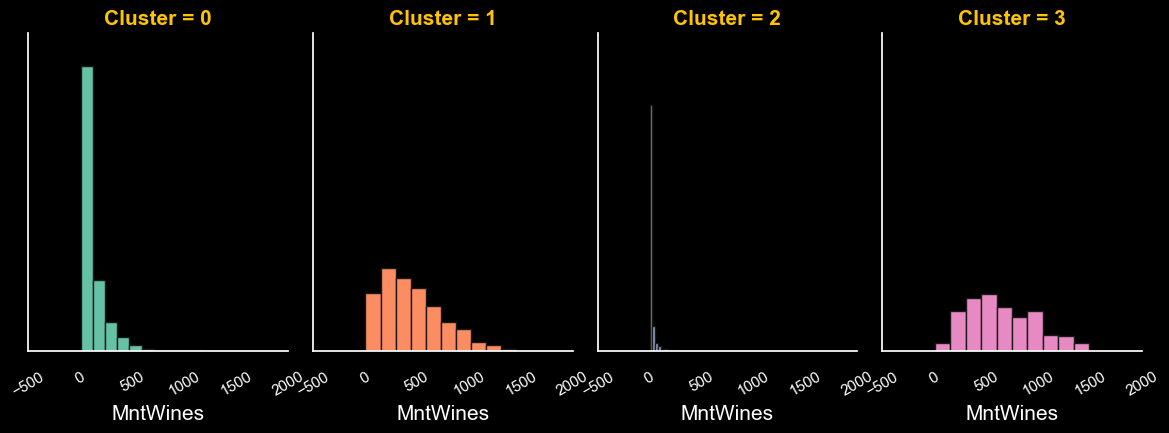

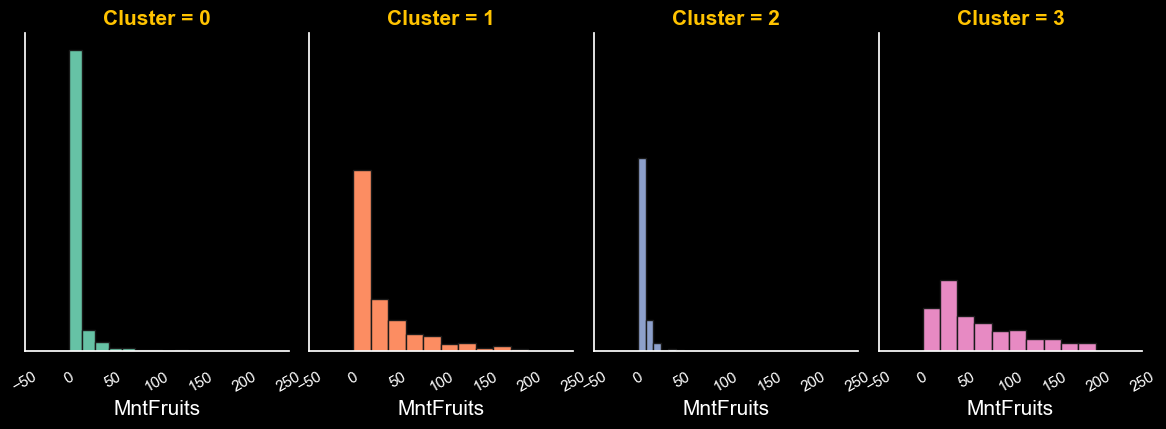

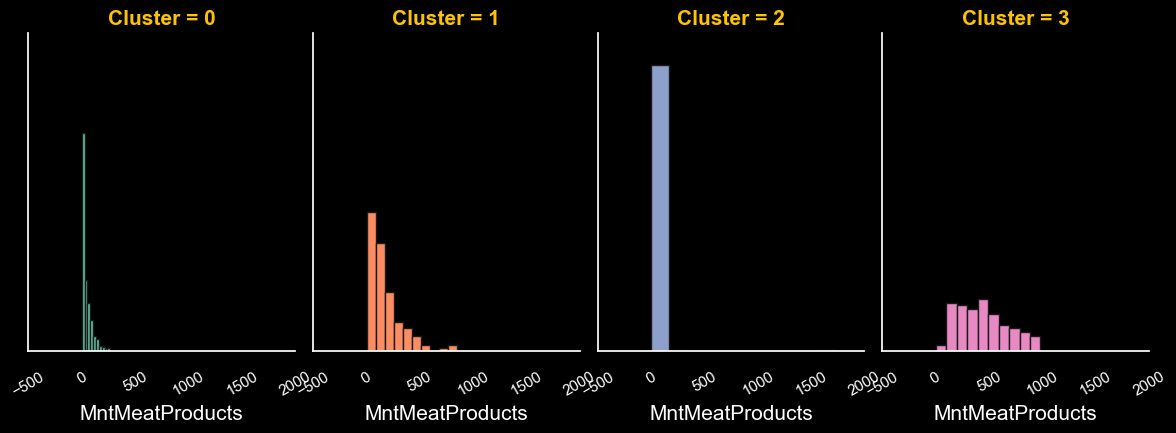

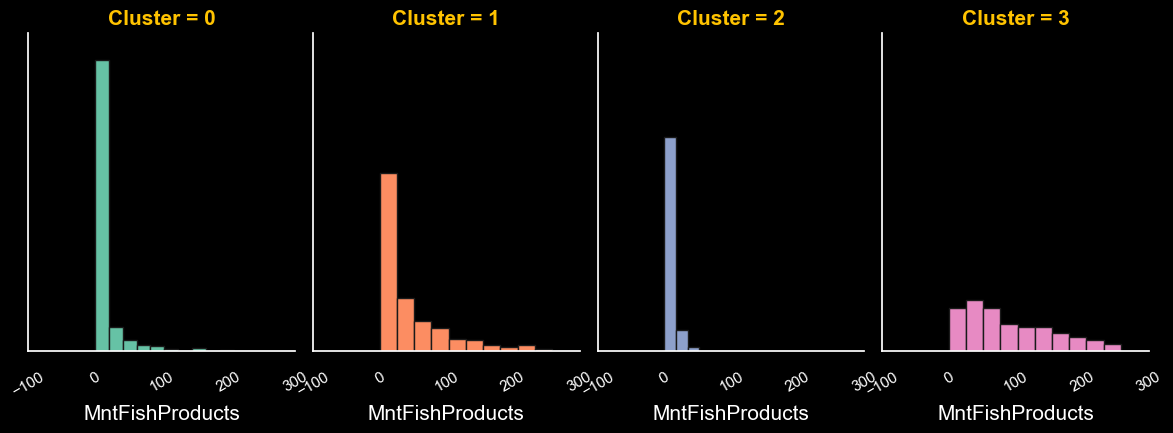

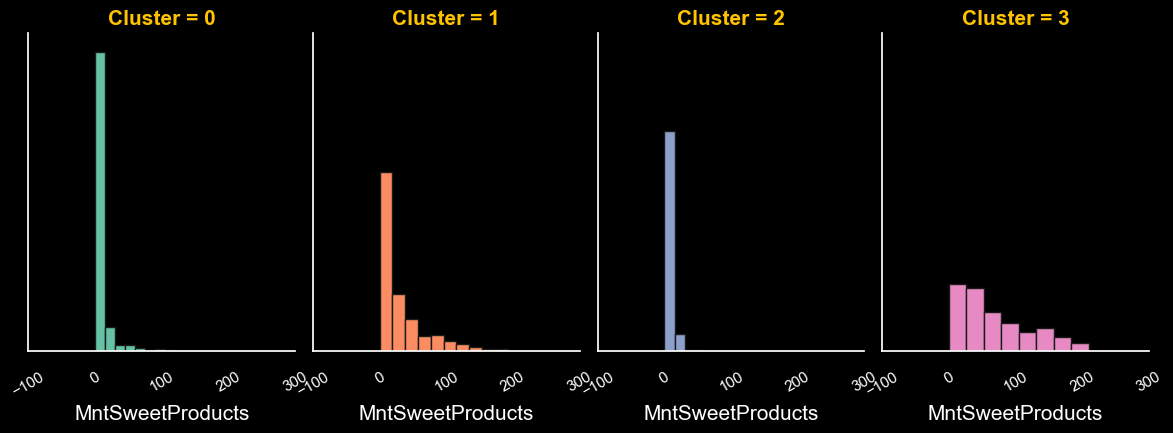

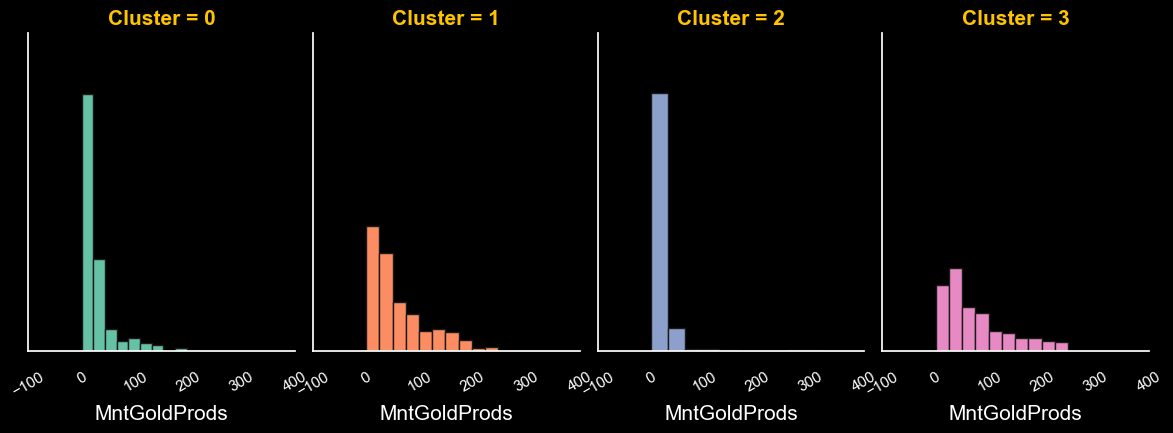

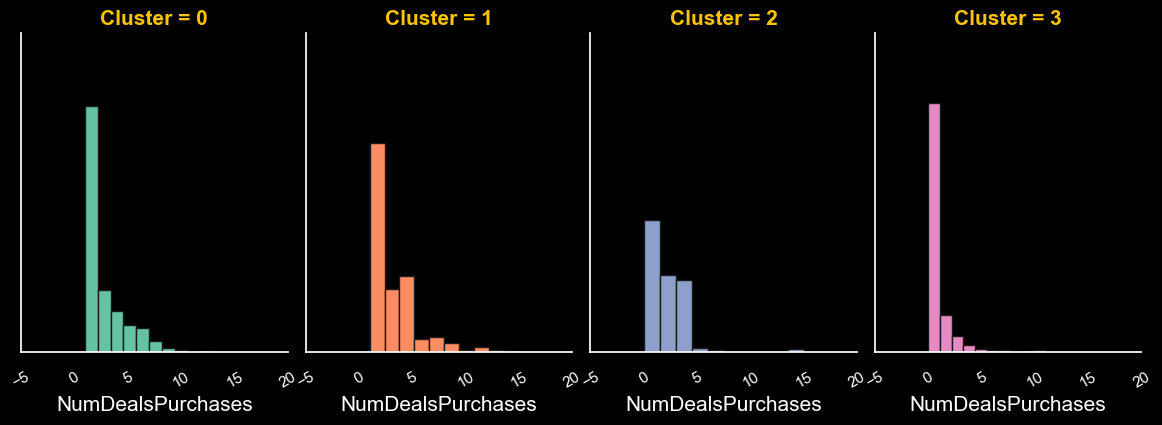

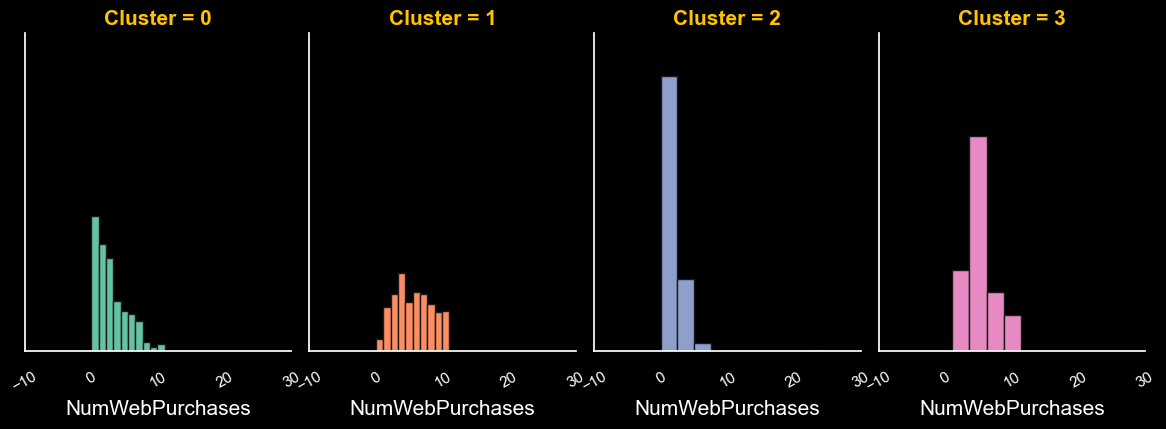

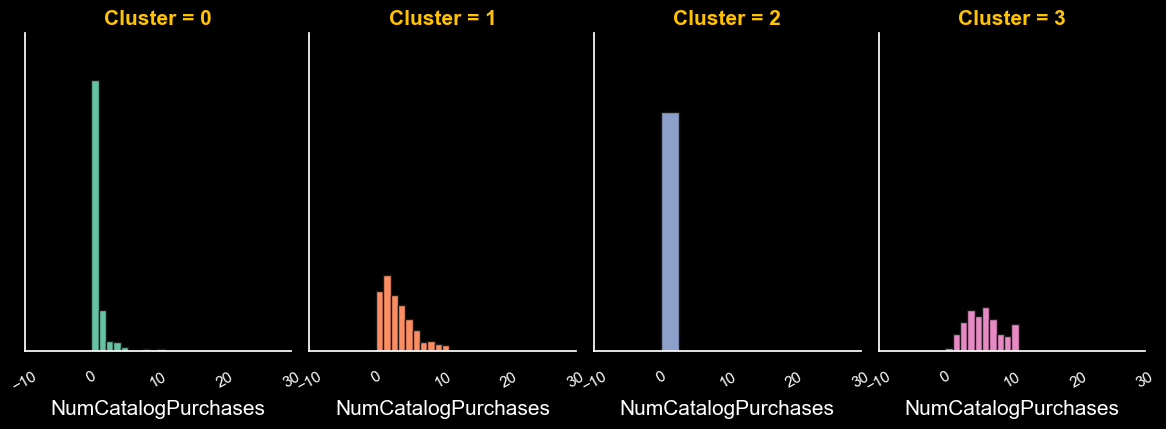

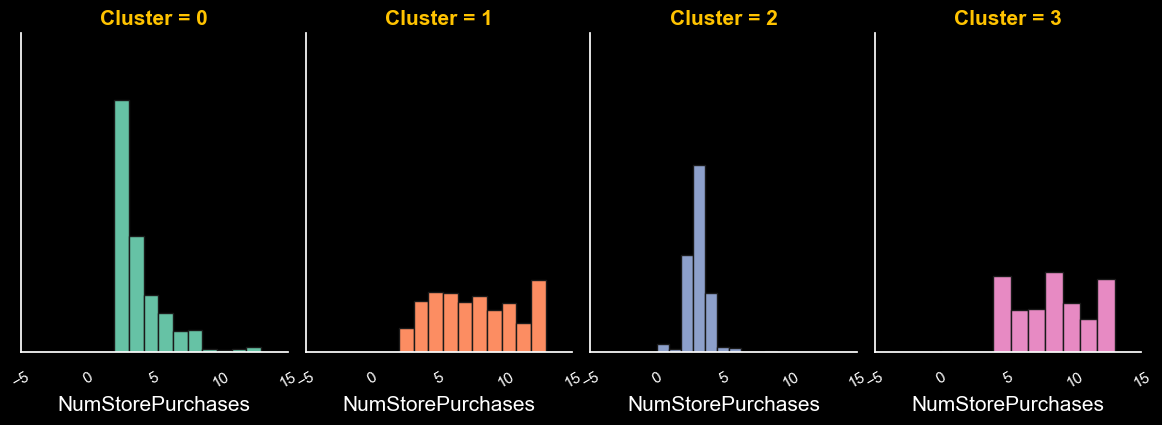

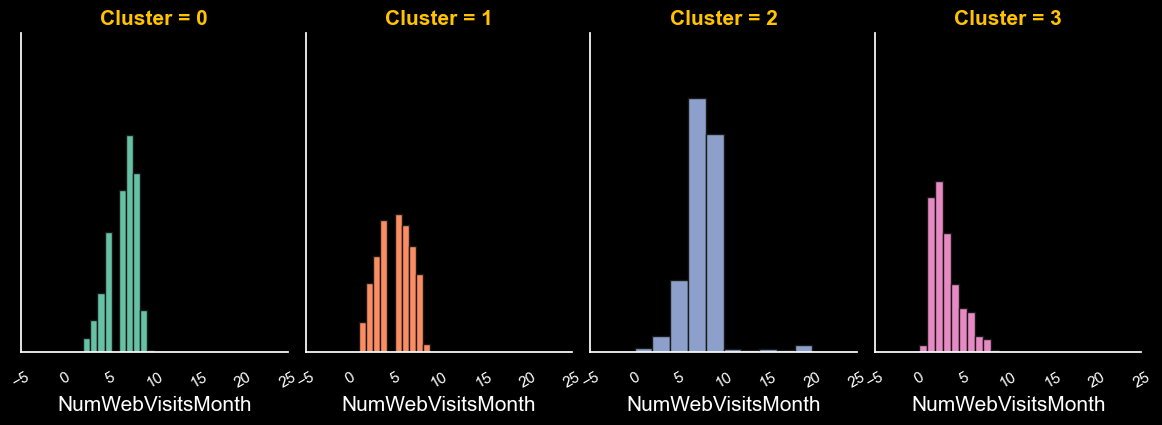

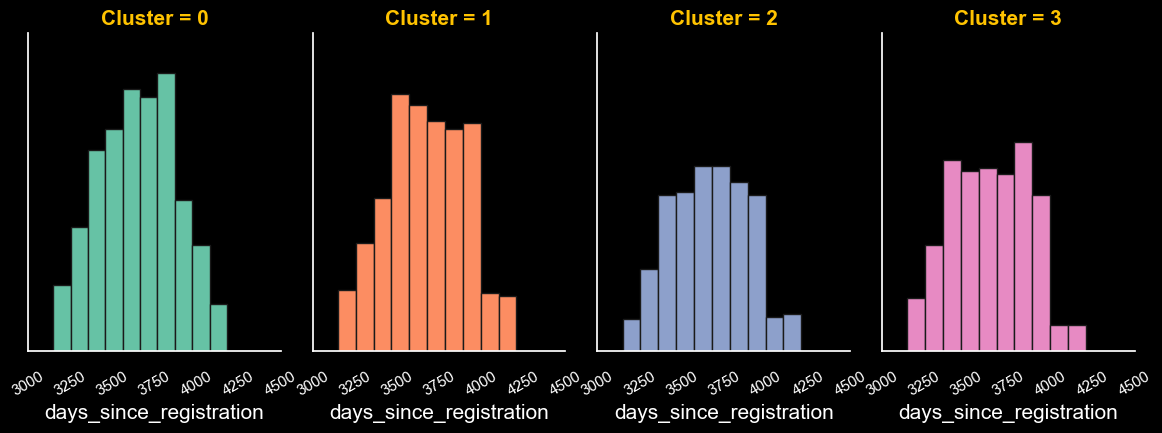

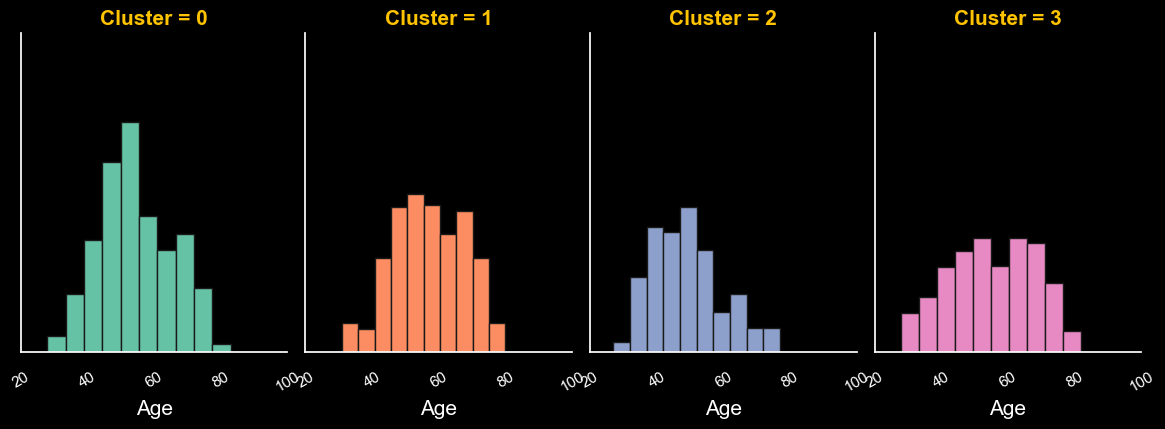

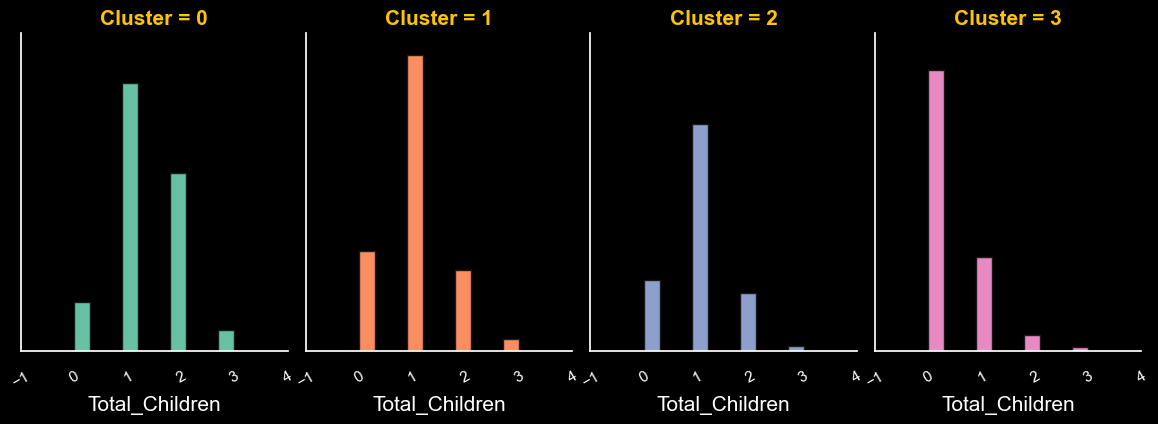

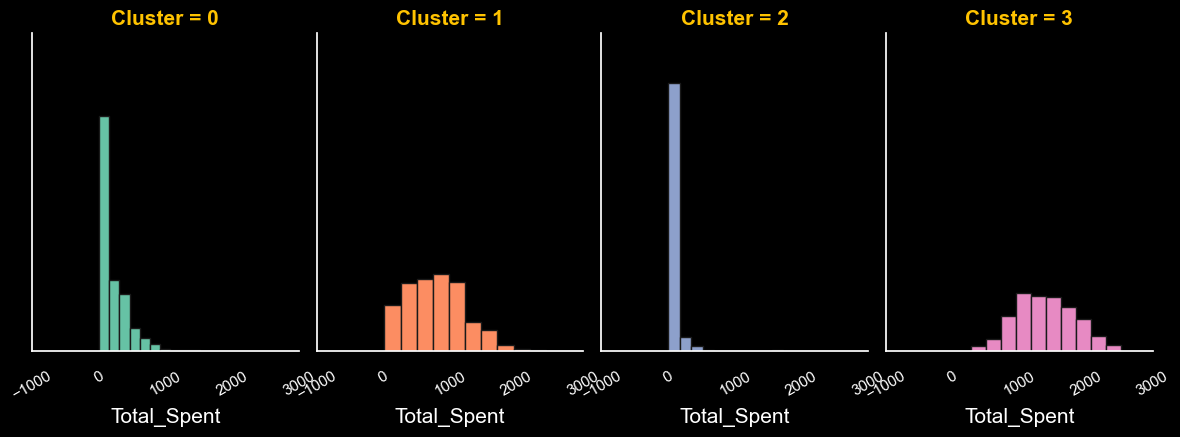

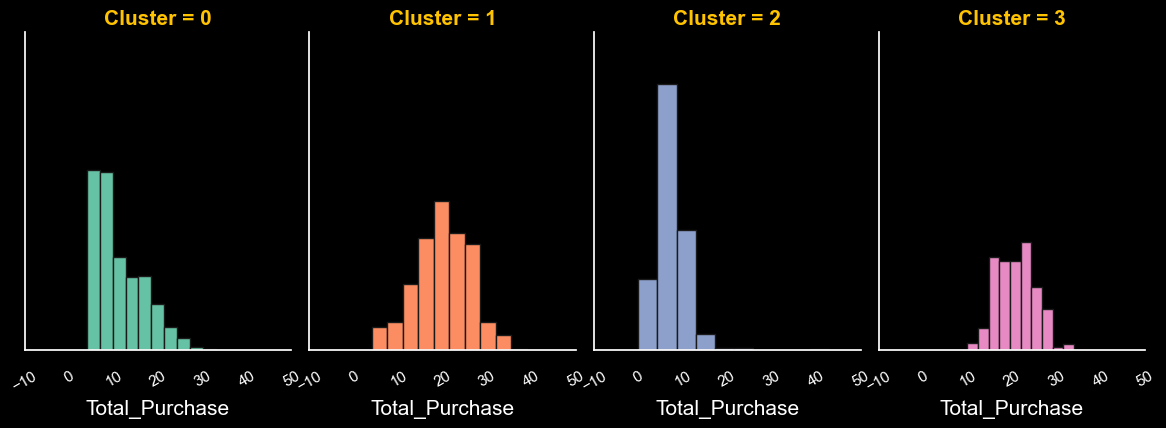

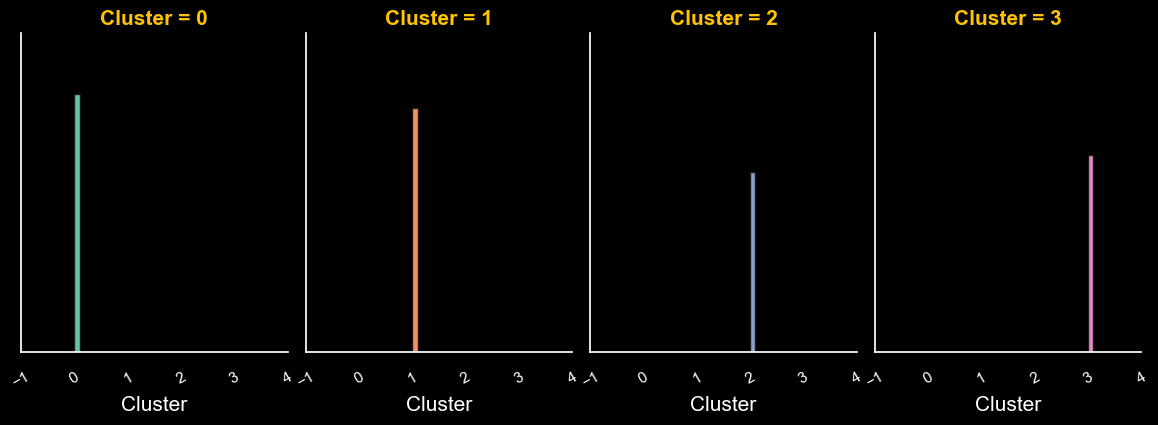

In [76]:
# Clusters interpretation kmeans
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False})

for i in df:
    g = sns.FacetGrid(df, col = "Cluster", hue = "Cluster", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=30, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)

### **Penjelasan Hasil Clustering KMeans**
**Cluster 0:**
- Income menengah bawah (25000-50000)
- Hemat dalam berbelanja
- Mayoritas memiliki anak
- Jarang membeli barang via katalog

**Cluster 1:**
- Income menengah atas (50000-75000)
- Lebih boros dalam berbelanja
- Suka membeli wine

**Cluster 2:**
- Income rendah (< 25000)
- Jarang berbelanja
- Orang berusia lebih muda
- Hampir tidak pernah membeli daging
- Membeli barang ketika ada diskon

**Cluster 3:**
- Income tinggi (> 75000)
- Mengeluarkan paling banyak uang ketika berbelanja
- Mayoritas tidak memiliki anak
- Suka membeli berbagai macam variasi produk
- Tidak menunggu diskon untuk membeli barang

### **Agglomerative Clustering**

Elbow Method untuk mencari jumlah cluster Agglomerative optimal:


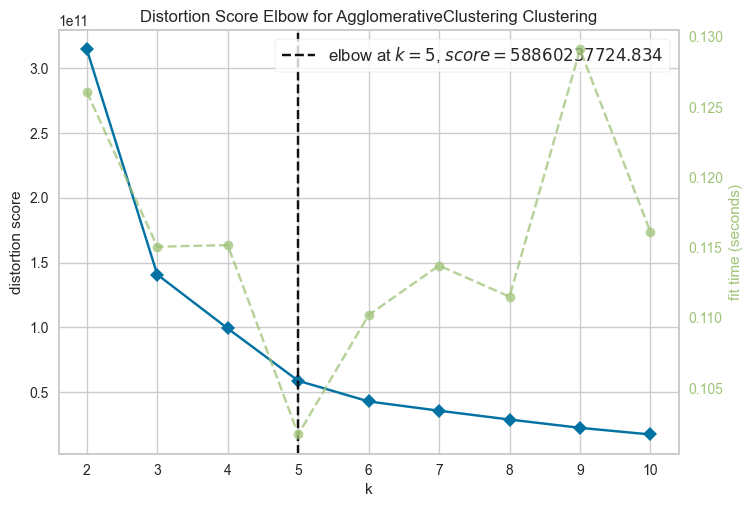

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
# Mencari jumlah cluster paling optimal untuk agglomerative clustering
print('Elbow Method untuk mencari jumlah cluster Agglomerative optimal:')
Elbow_M = KElbowVisualizer(AgglomerativeClustering(), k=10)
Elbow_M.fit(df)
Elbow_M.show()

Tampak bahwa paling optimal adalah 5 cluster

In [324]:
ac = AgglomerativeClustering(n_clusters=5)
ac.fit(df)

AgglomerativeClustering(n_clusters=5)

In [325]:
with open('models/agglomerative.pickle', 'wb') as f:
    pickle.dump(ac, f)

In [397]:
ac = AgglomerativeClustering(n_clusters=5)
ac = ac.fit_predict(df)
df['Cluster'] = ac

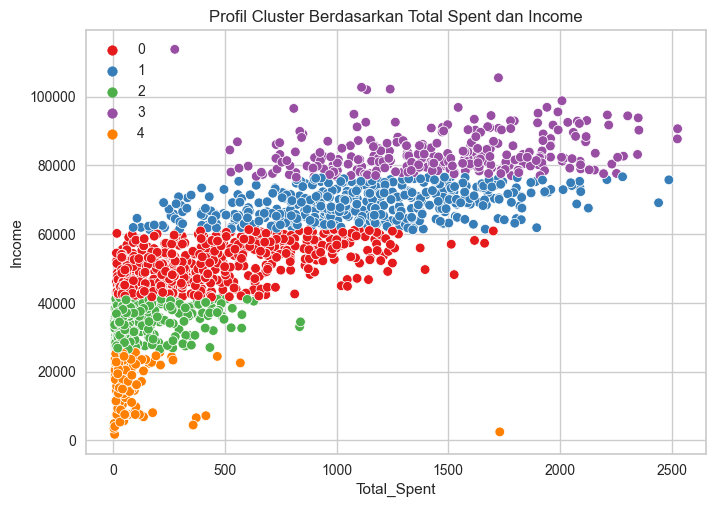

In [398]:
pl = sns.scatterplot(data = df,x=df["Total_Spent"], y=df["Income"],hue=df["Cluster"], palette="Set1")
pl.set_title("Profil Cluster Berdasarkan Total Spent dan Income")
plt.legend()
plt.show()

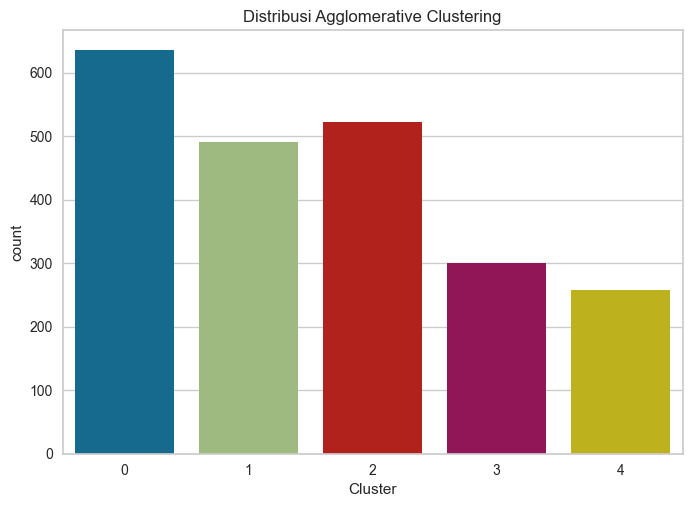

In [399]:
pl = sns.countplot(x=df["Cluster"])
pl.set_title("Distribusi Agglomerative Clustering")
plt.show()

c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  

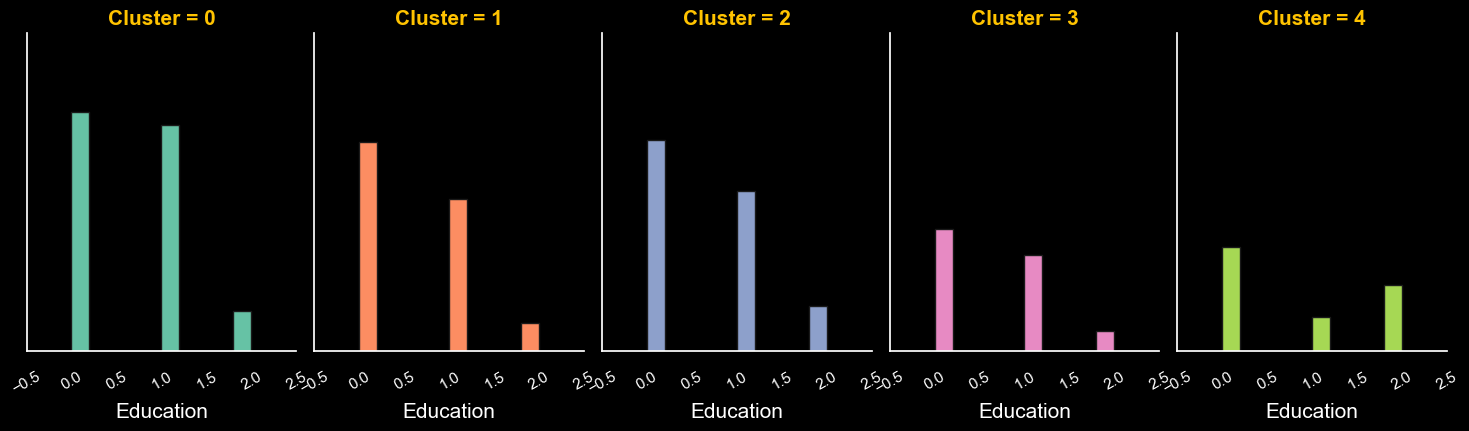

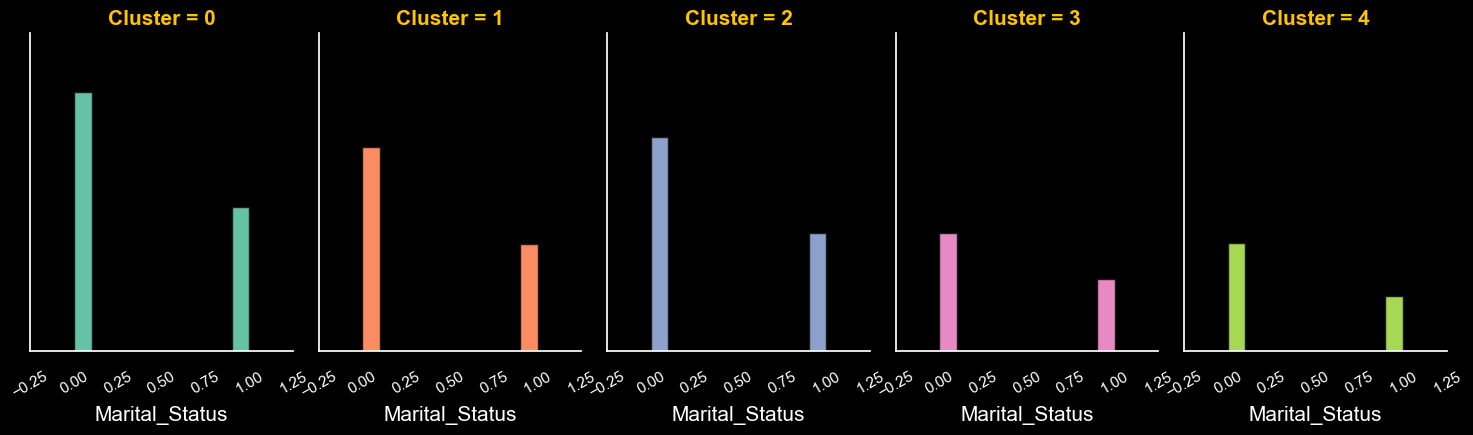

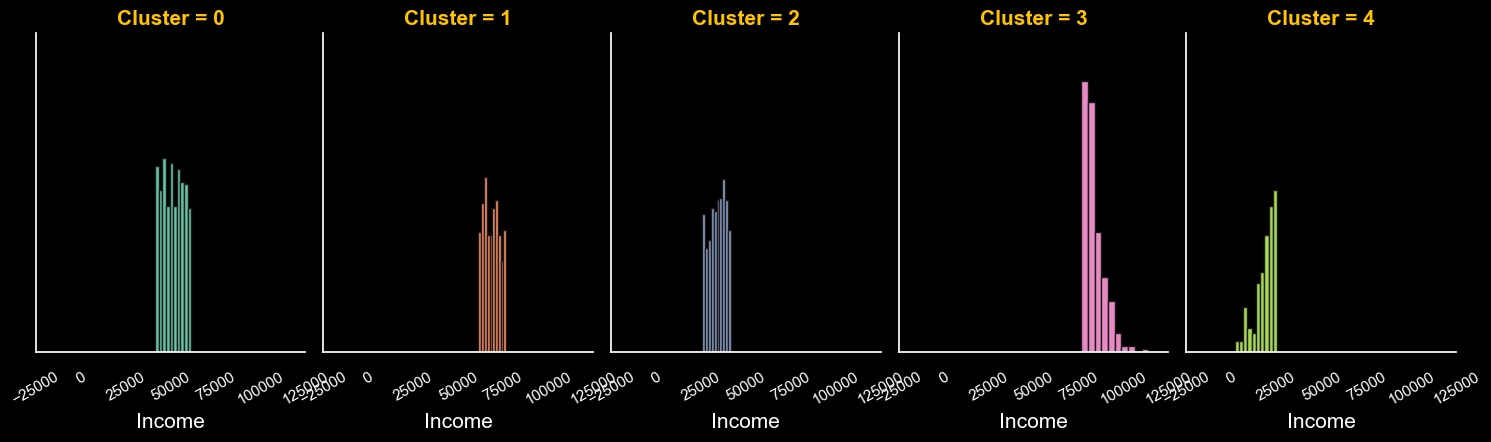

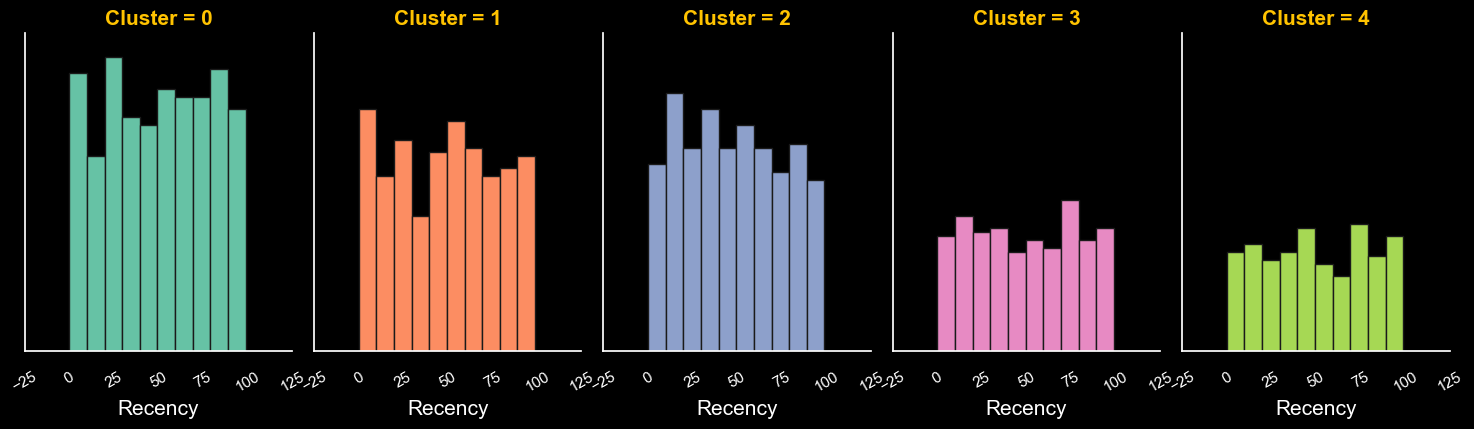

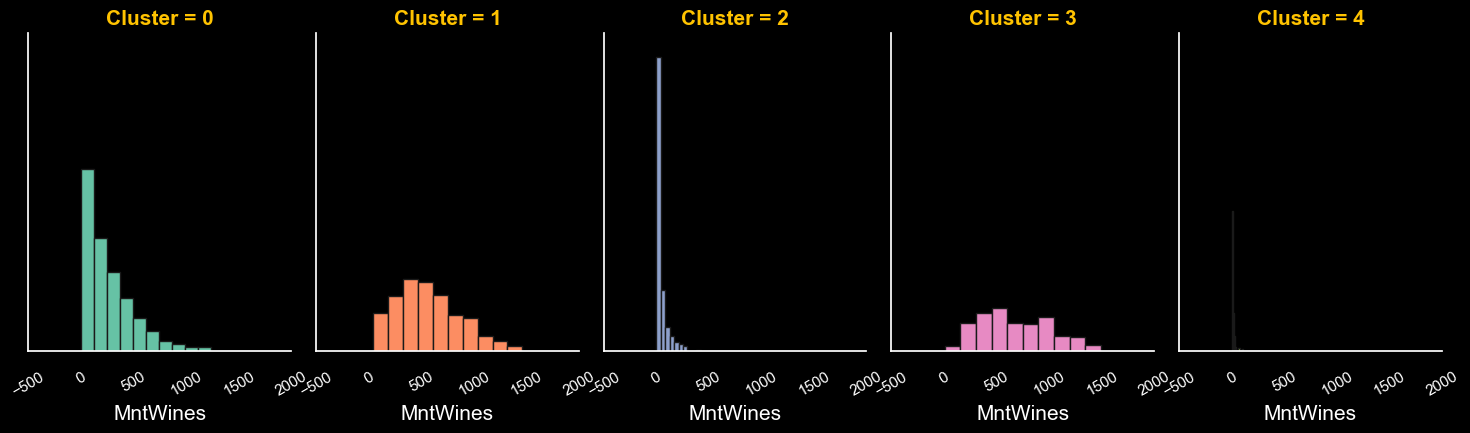

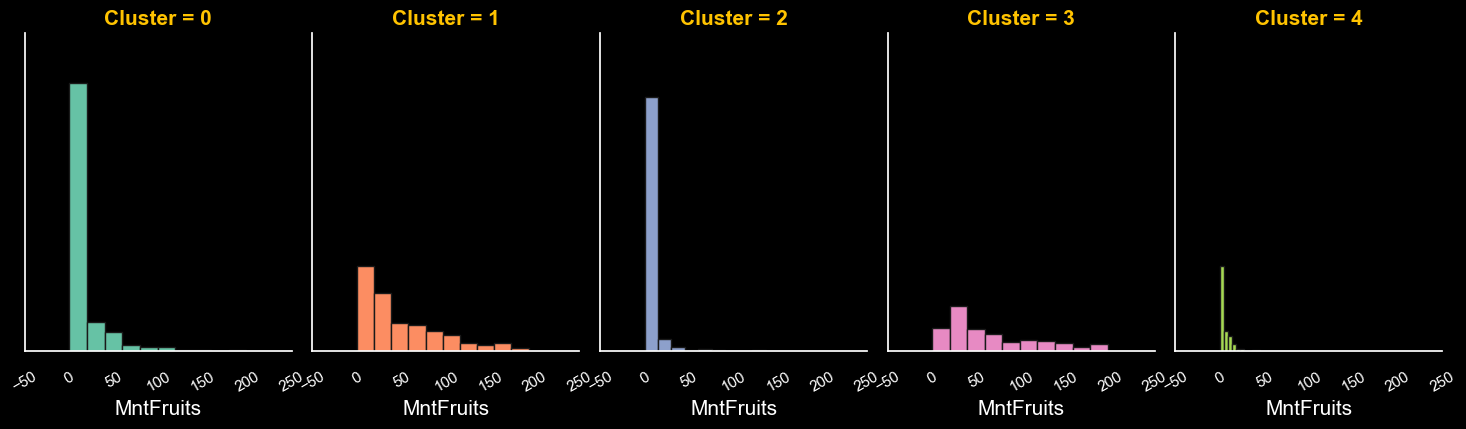

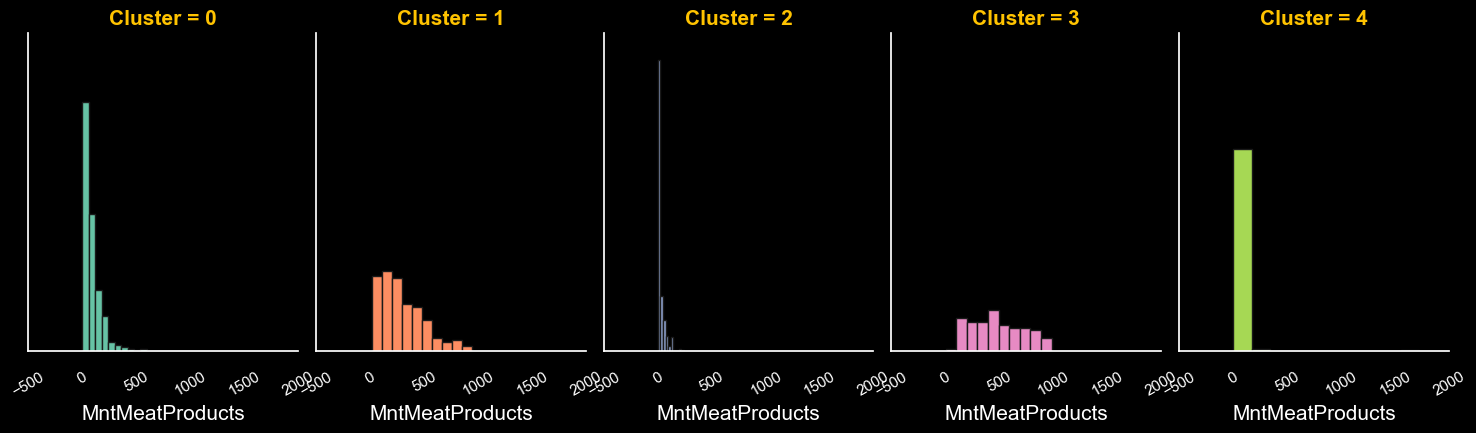

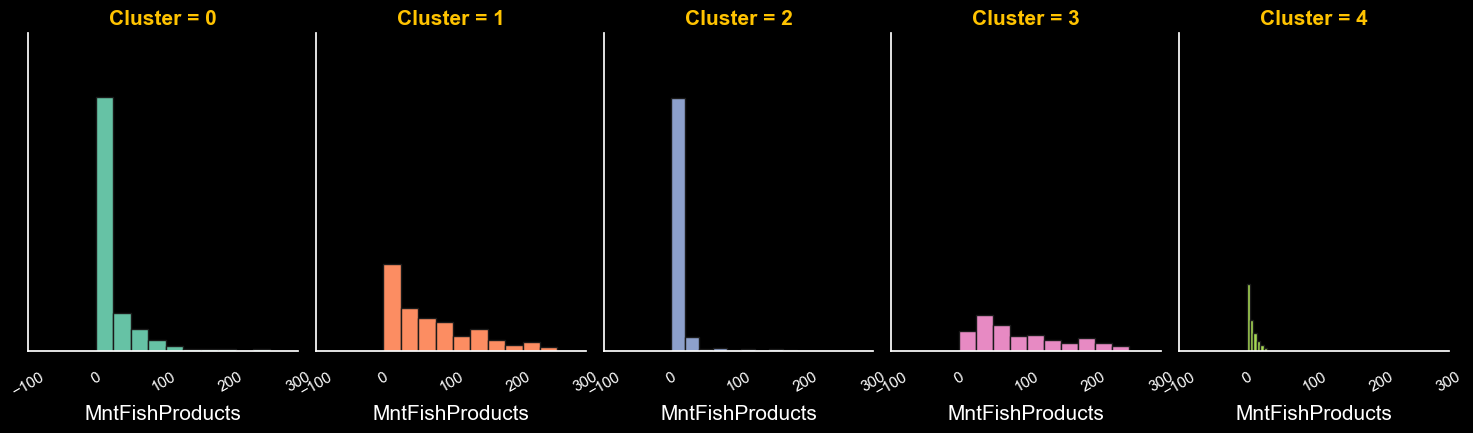

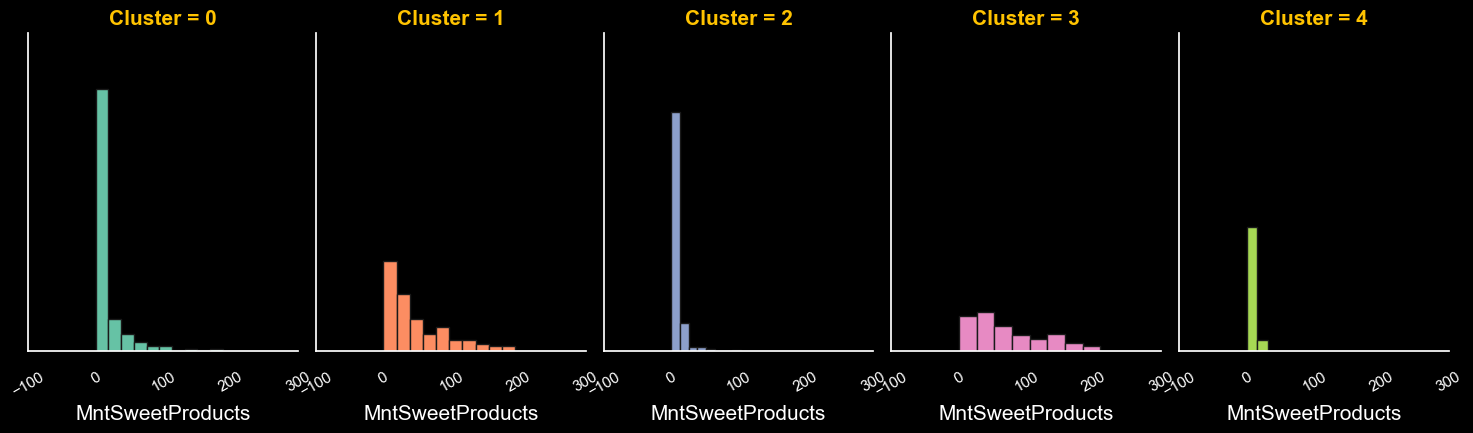

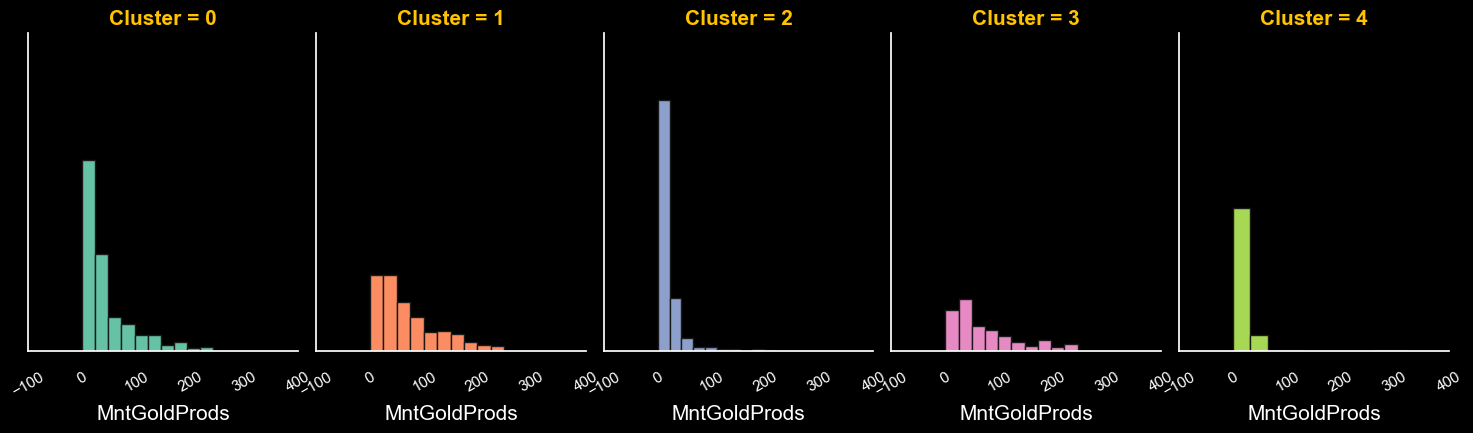

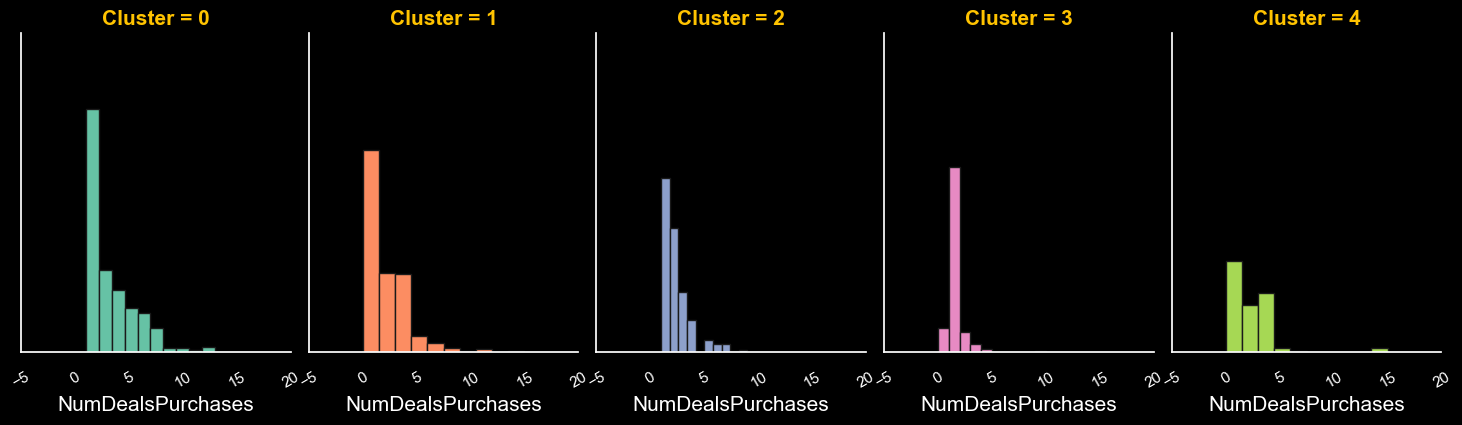

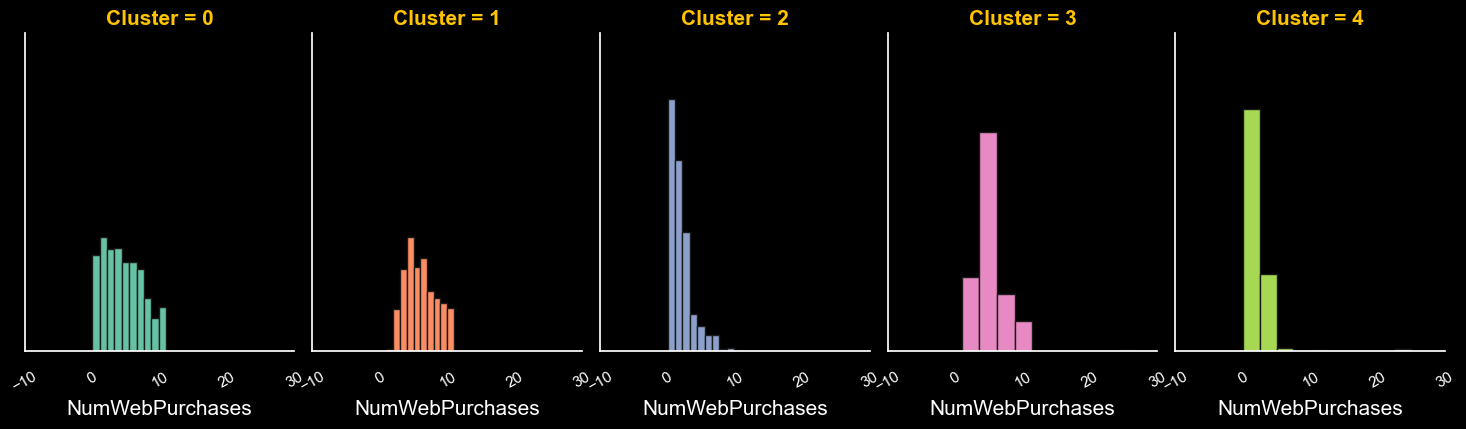

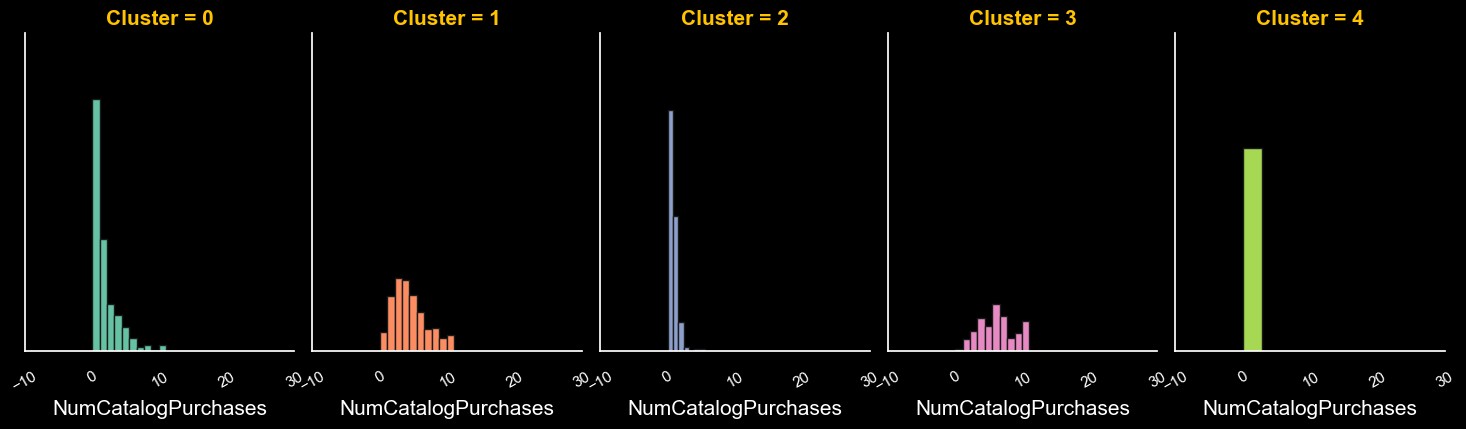

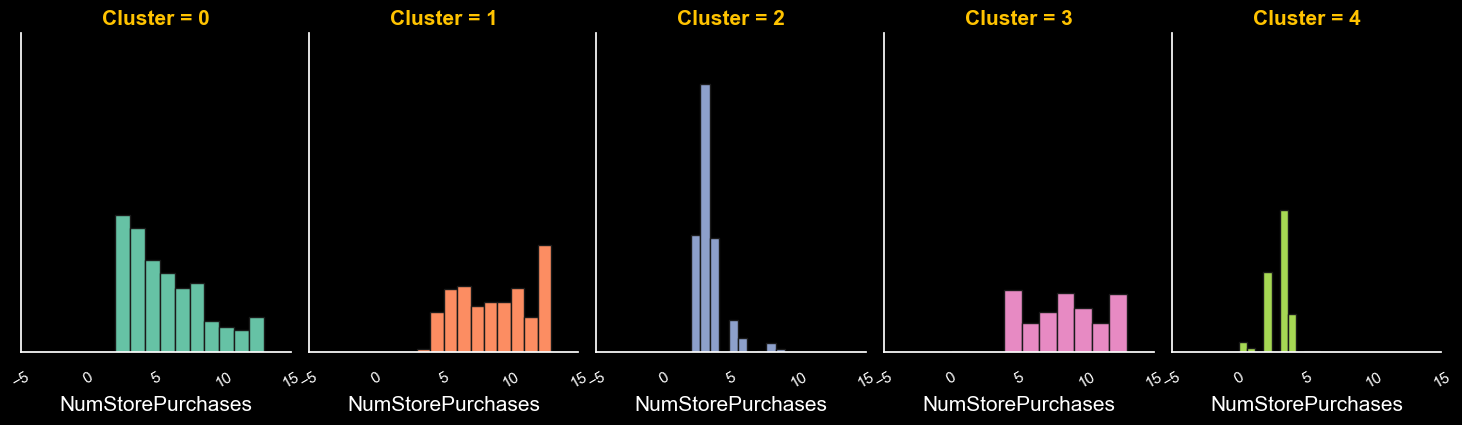

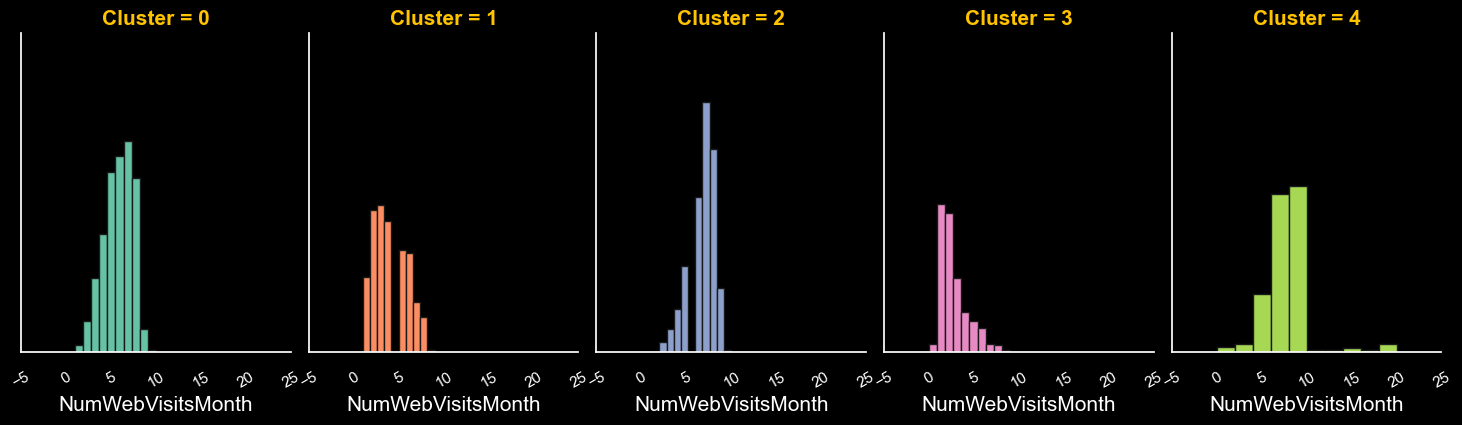

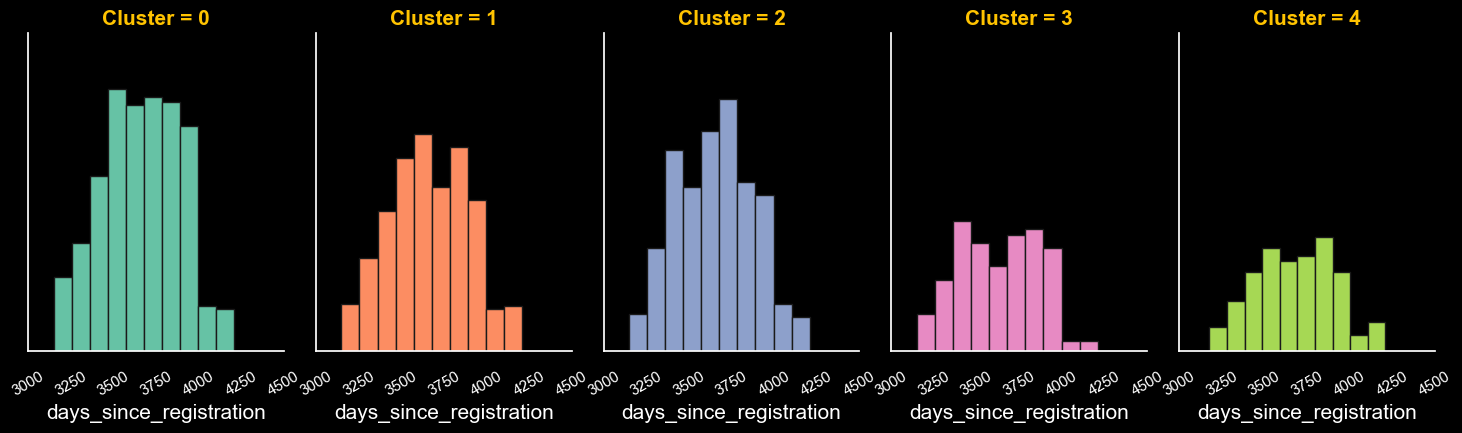

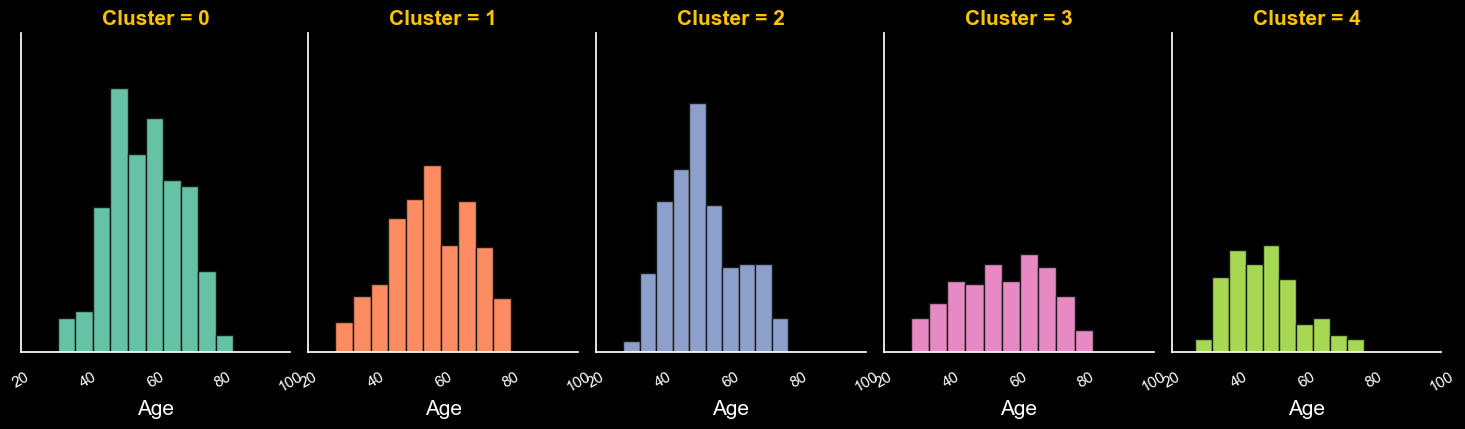

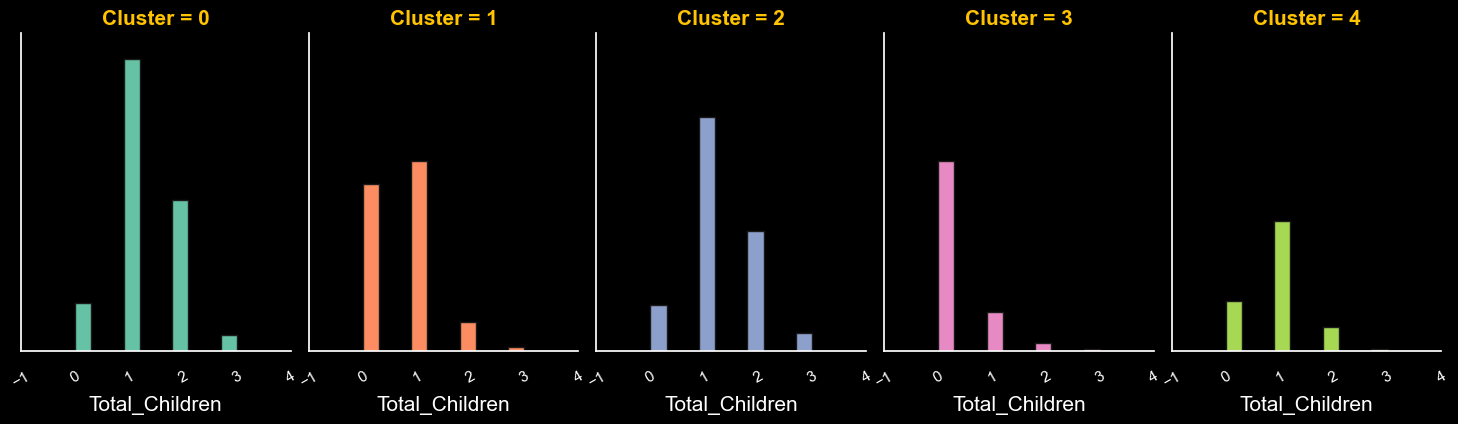

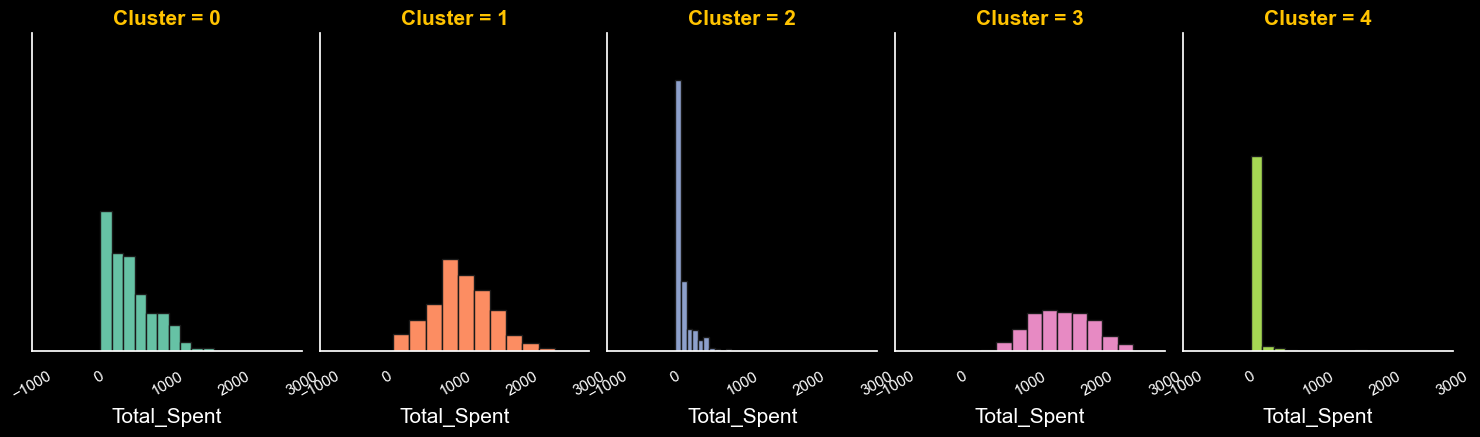

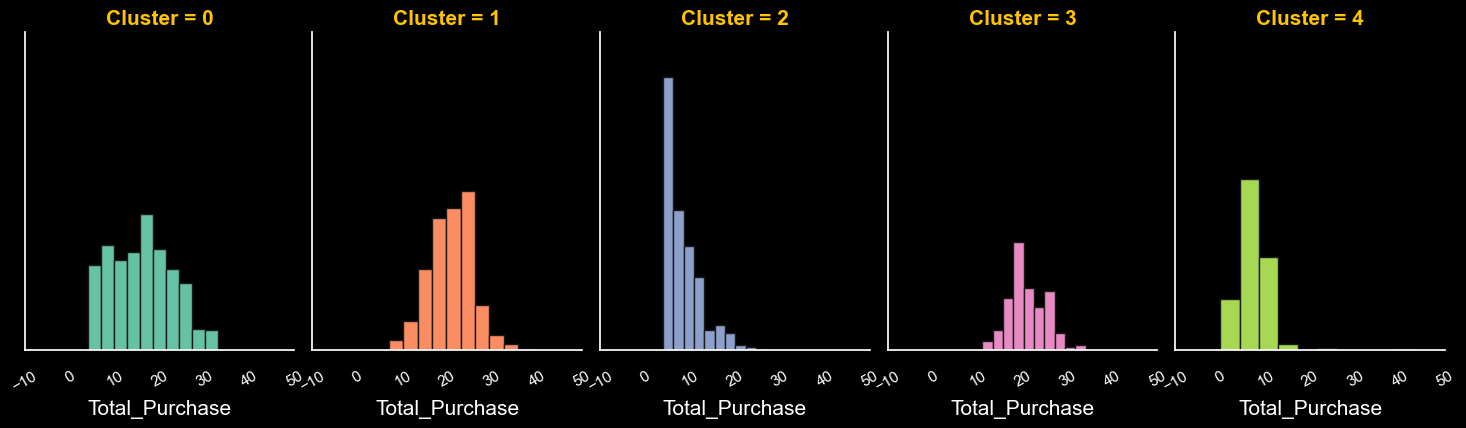

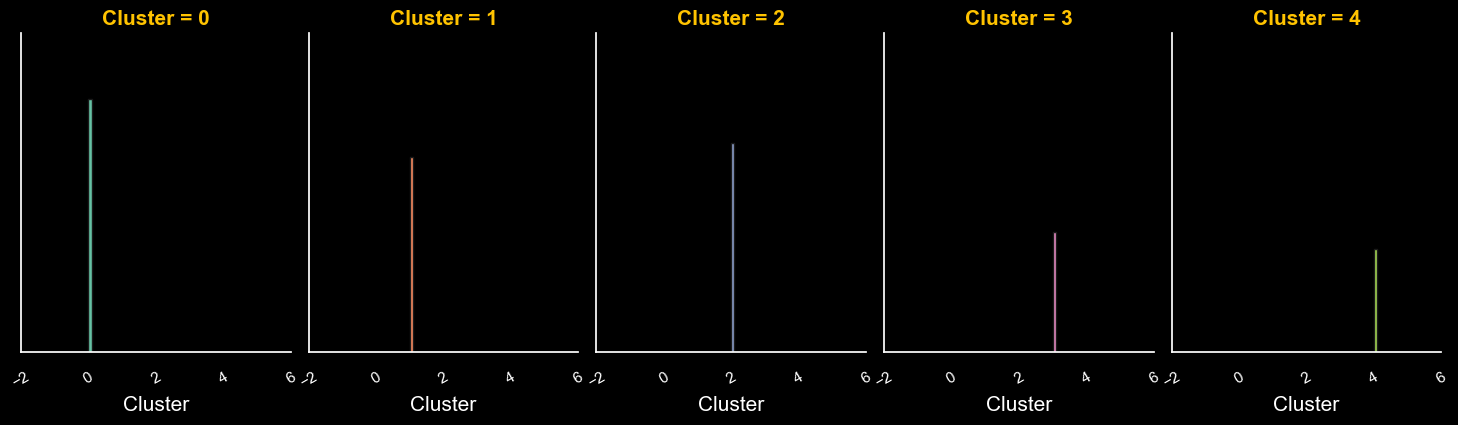

In [54]:
# Clusters interpretation ac
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False})

for i in df:
    g = sns.FacetGrid(df, col = "Cluster", hue = "Cluster", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=30, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)

### **Penjelasan Hasil Clustering Agglomerative**
**Cluster 0:** 
- Income menengah
- Sering membeli banyak barang
- Lebih sering membeli barang murah
- Mayoritas memiliki anak

**Cluster 1:**
- Income menengah atas
- Sering membeli banyak barang
- Lebih sering membeli barang mahal
- Suka membeli wine dan daging

**Cluster 2:**
- Income menengah bawah
- Jarang membeli barang
- Mayoritas memiliki anak

**Cluster 3:**
- Income tinggi
- Paling banyak menghabiskan uang ketika berbelanja
- Mayoritas tidak memiliki anak
- Suka membeli berbagai jenis variasi produk

**Cluster 4:**
- Income rendah
- Paling jarang membeli barang
- Maksimal memiliki 2 anak
- Mayoritas berusia muda
- Hampir tidak pernah membeli wine dan daging
- Hampir tidak pernah membeli via katalog

### **Birch Clustering**

Elbow Method untuk mencari jumlah cluster Birch optimal:


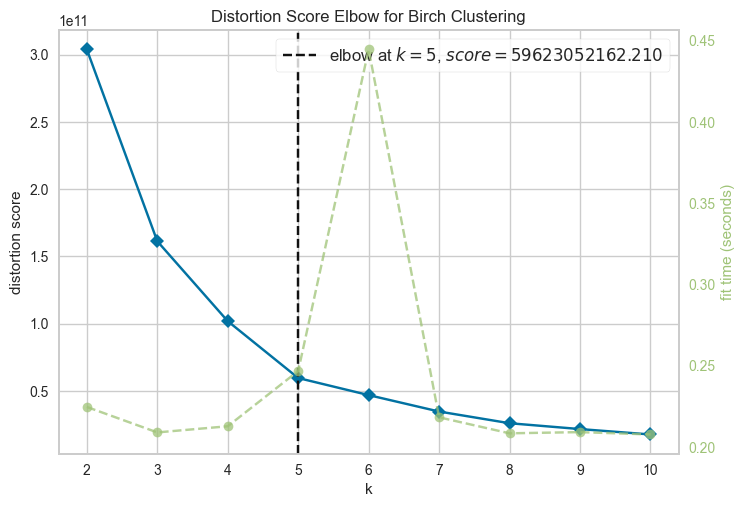

<AxesSubplot:title={'center':'Distortion Score Elbow for Birch Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
# Mencari jumlah cluster paling optimal untuk birch clustering
print('Elbow Method untuk mencari jumlah cluster Birch optimal:')
Elbow_M = KElbowVisualizer(Birch(), k=10)
Elbow_M.fit(df)
Elbow_M.show()

Tampak bahwa paling optimal adalah 5 cluster

In [435]:
birch = Birch(n_clusters=5, threshold=0.01)
birch.fit(df)

Birch(n_clusters=5, threshold=0.01)

In [436]:
with open('models/birch.pickle', 'wb') as f:
    pickle.dump(birch, f)

In [437]:
birch = birch.predict(df)
df['Cluster'] = birch

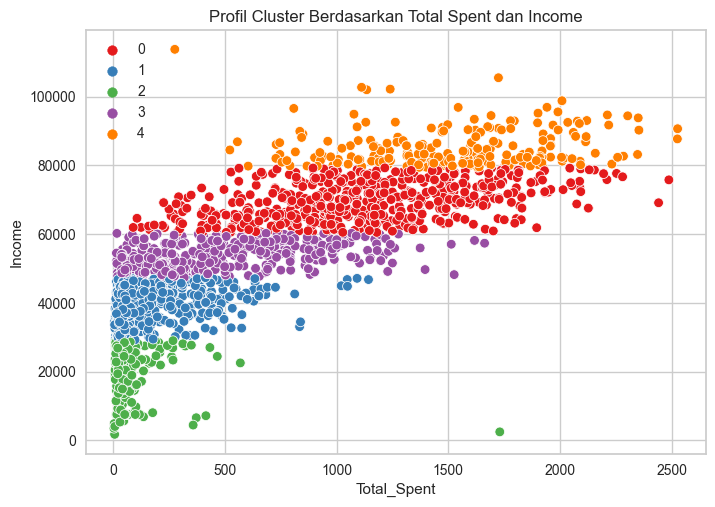

In [438]:
pl = sns.scatterplot(data = df,x=df["Total_Spent"], y=df["Income"],hue=df["Cluster"], palette="Set1")
pl.set_title("Profil Cluster Berdasarkan Total Spent dan Income")
plt.legend()
plt.show()

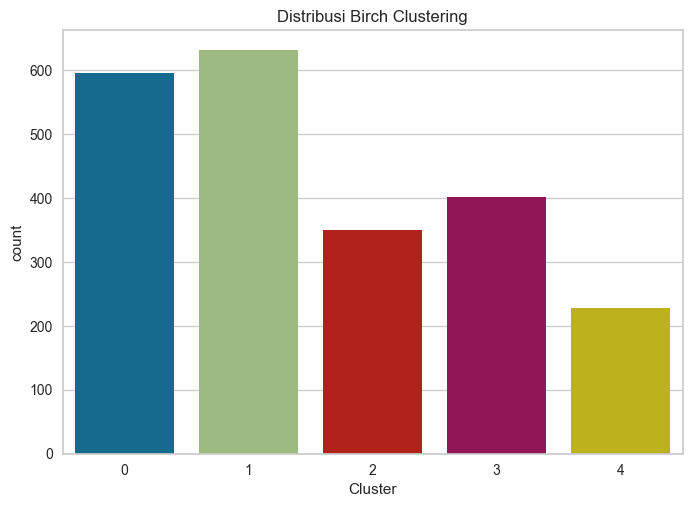

In [37]:
#Plotting countplot of clusters
pl = sns.countplot(x=df["Cluster"])
pl.set_title("Distribusi Birch Clustering")
plt.show()

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Nando\lib\site-packages\seaborn\axisgrid.py:676: FutureWarning: iteritems is d

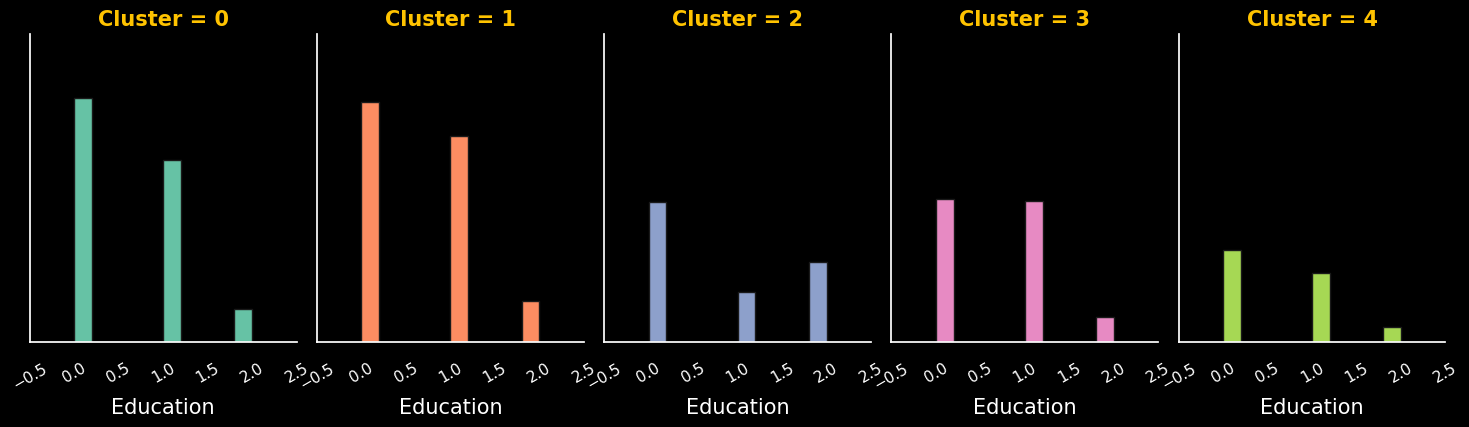

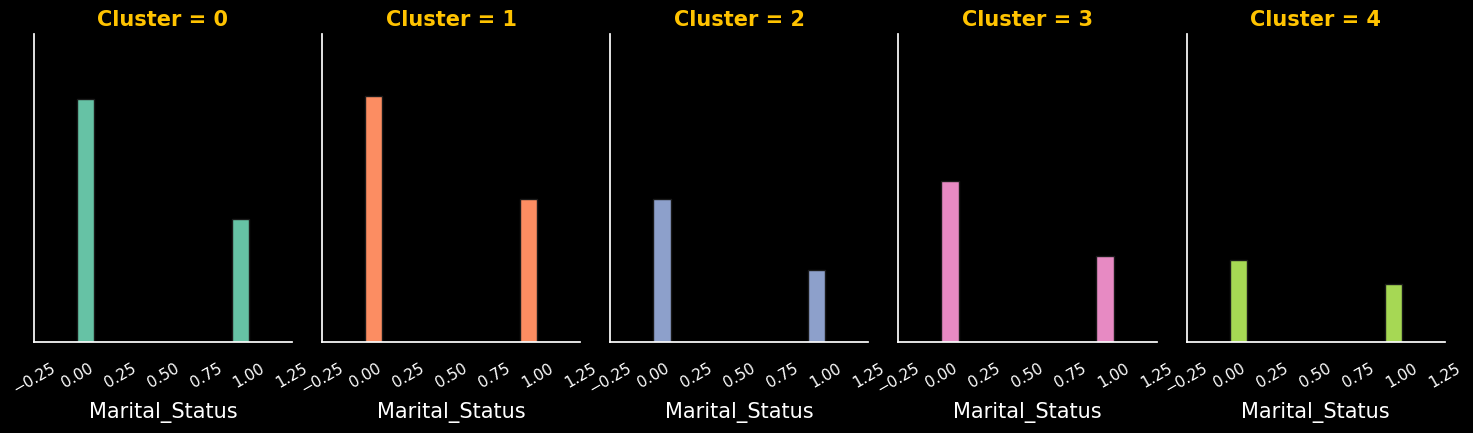

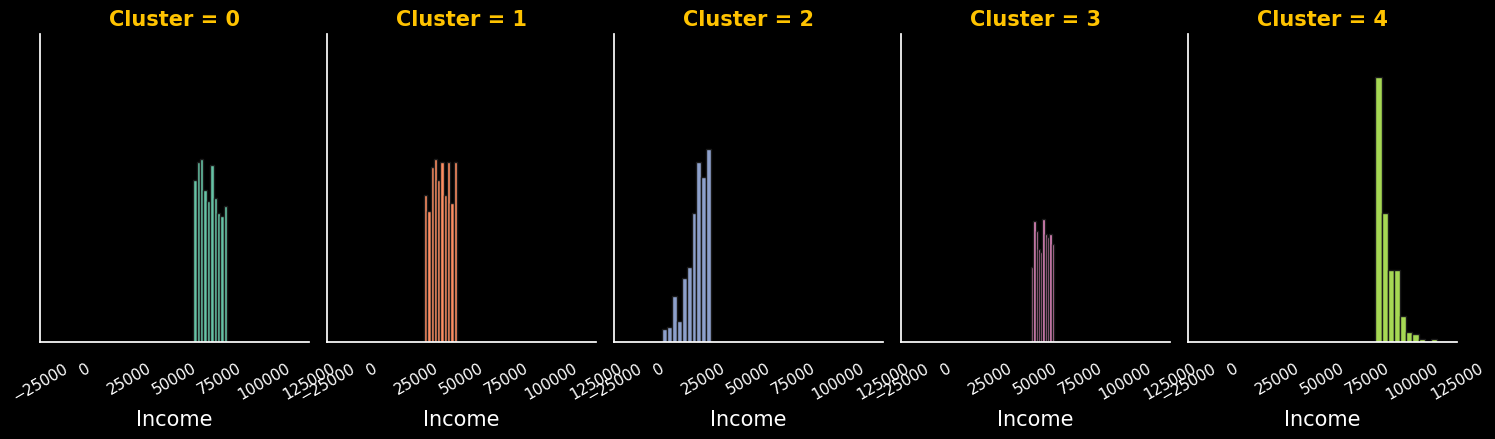

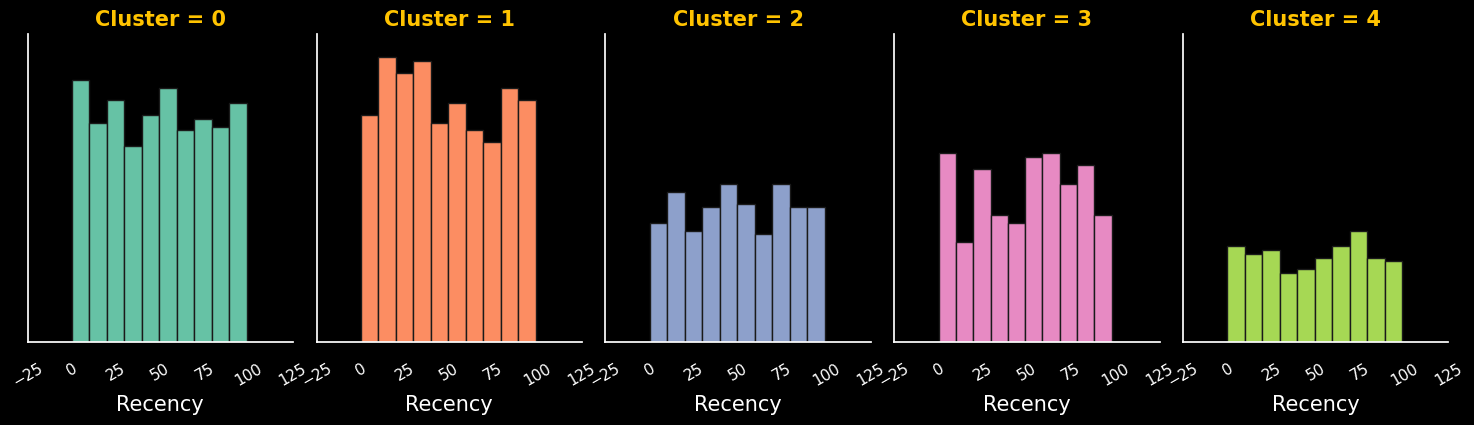

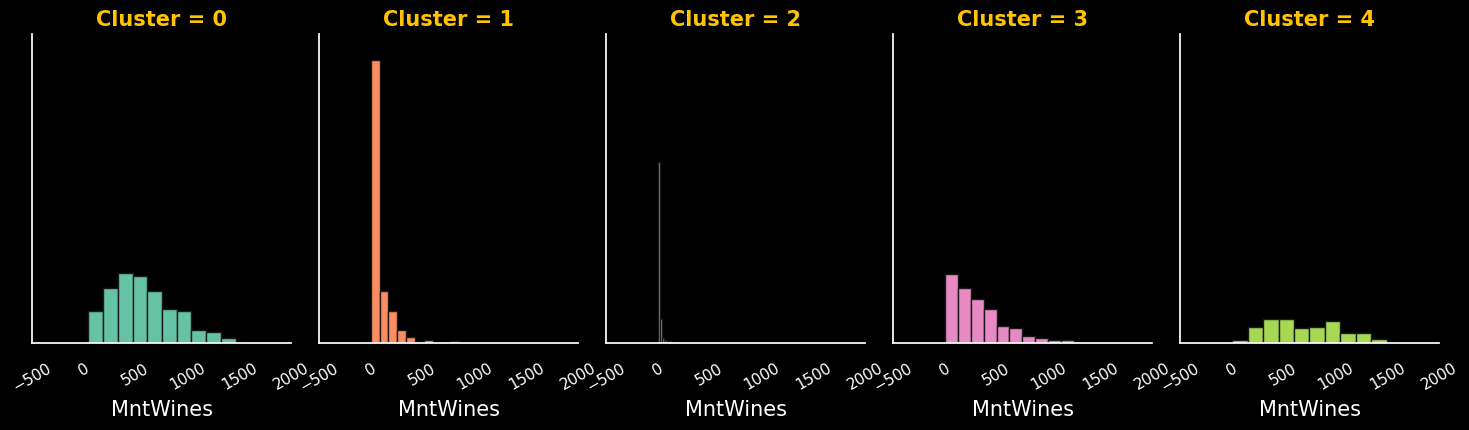

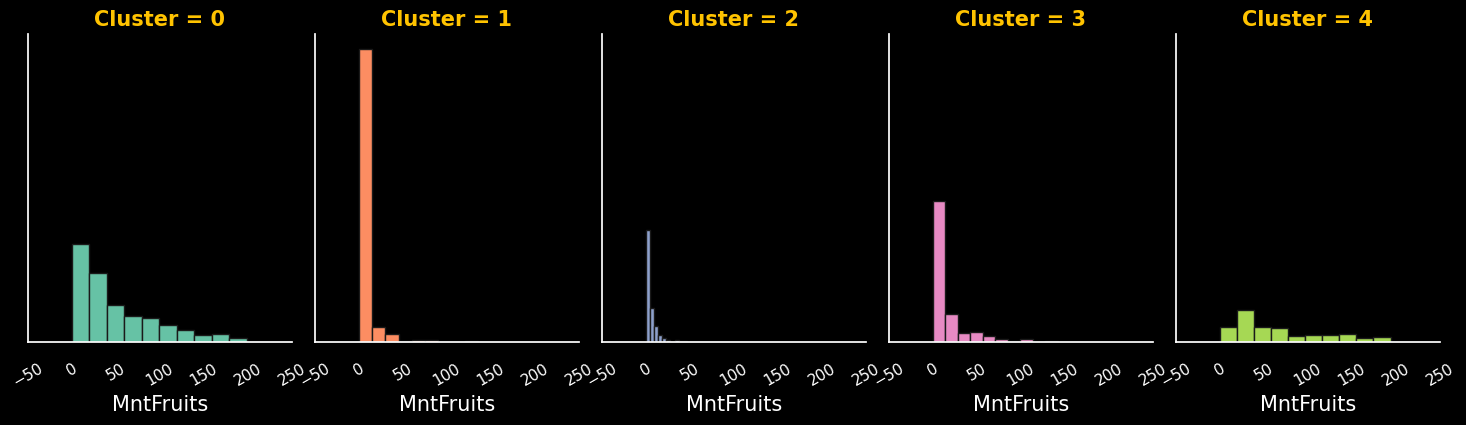

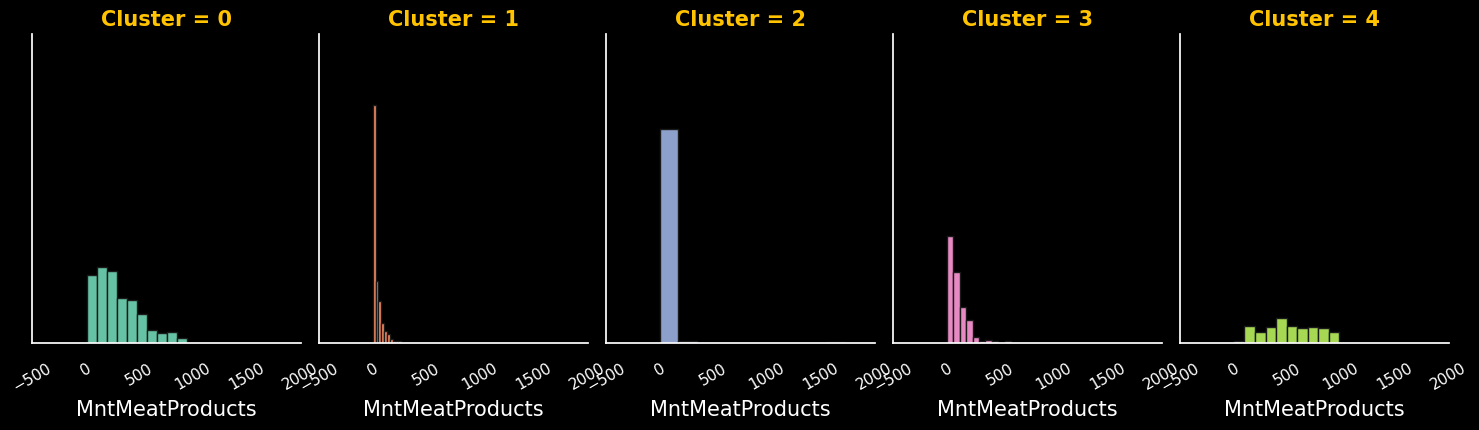

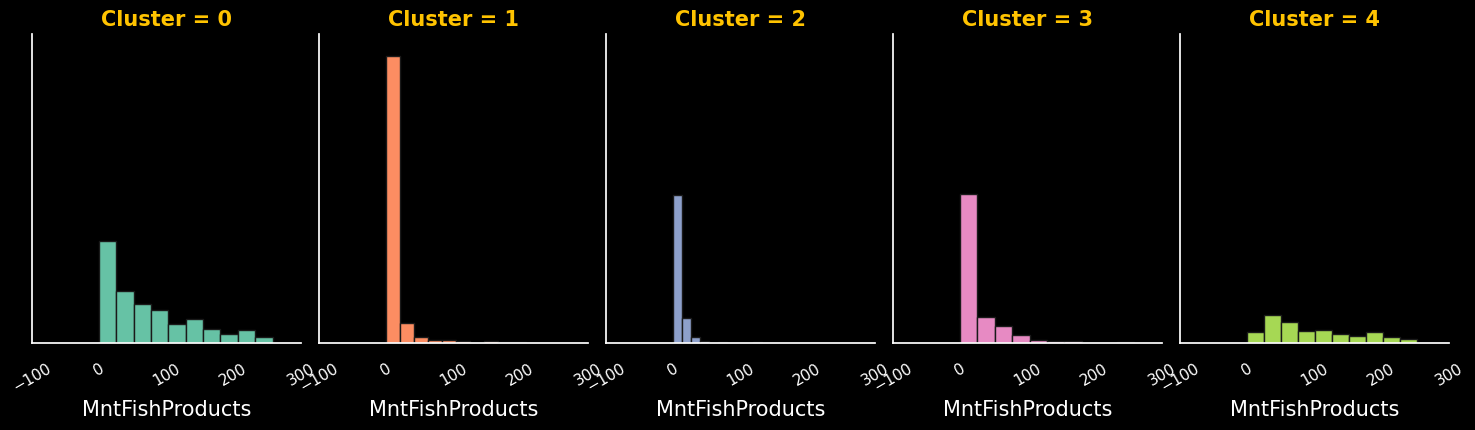

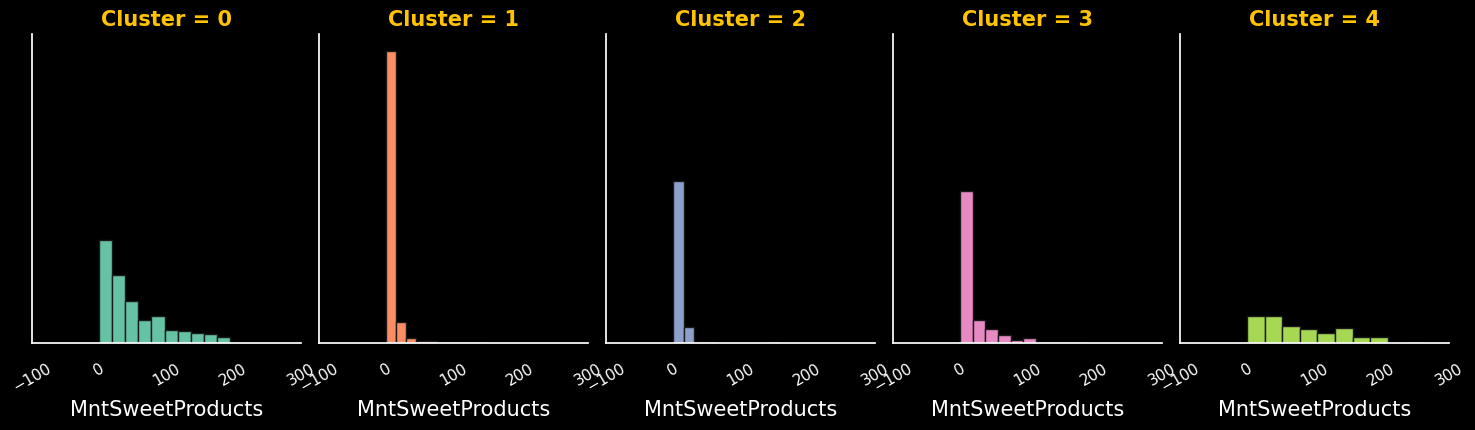

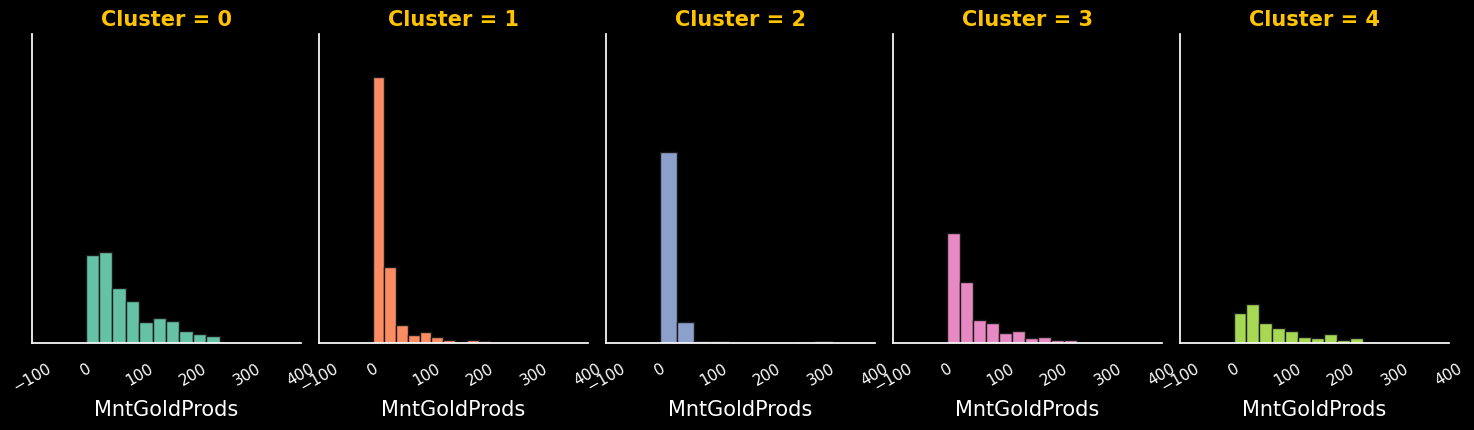

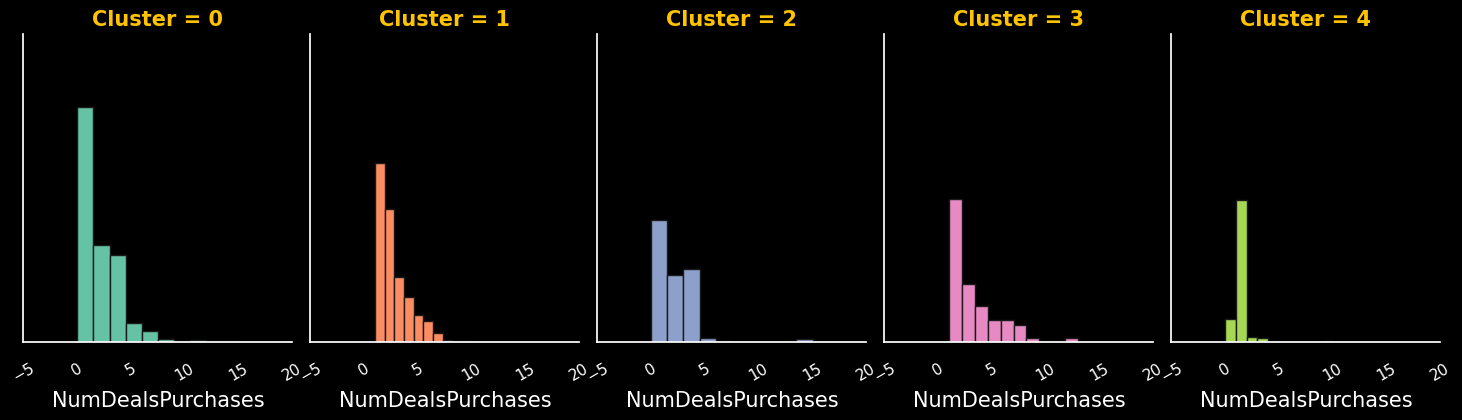

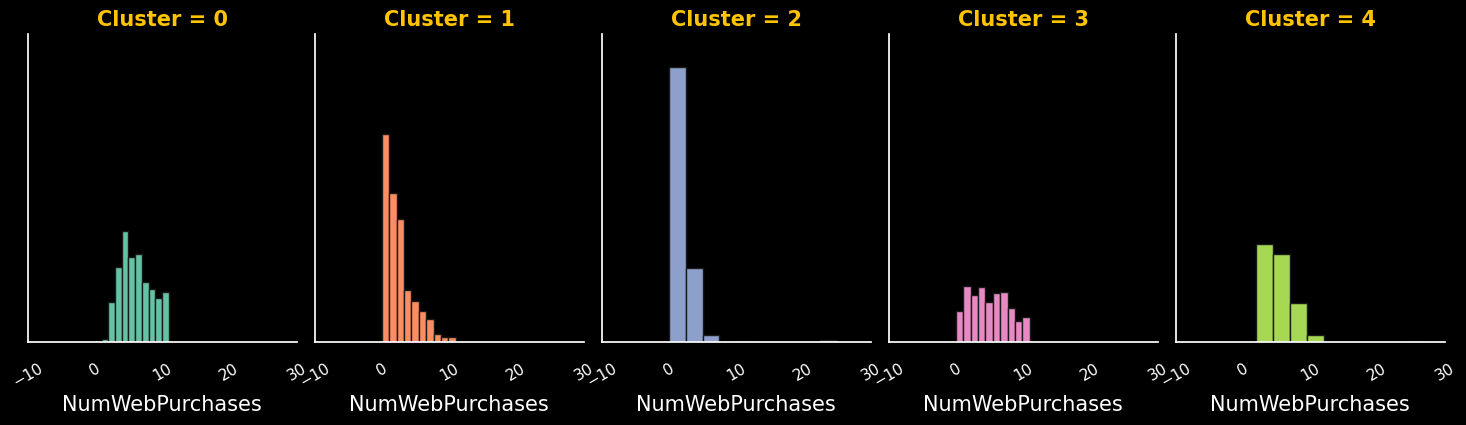

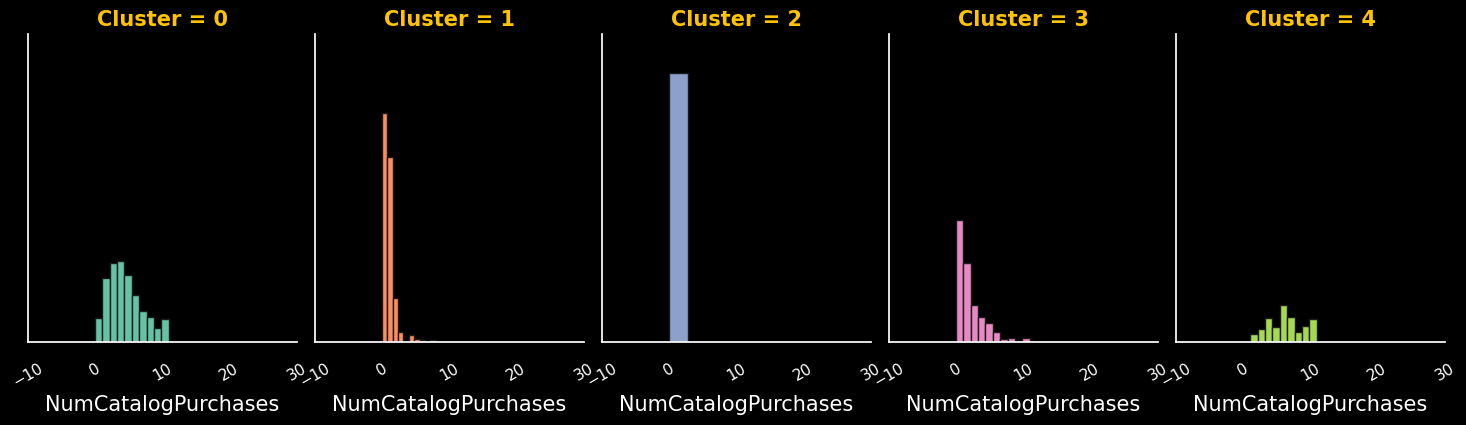

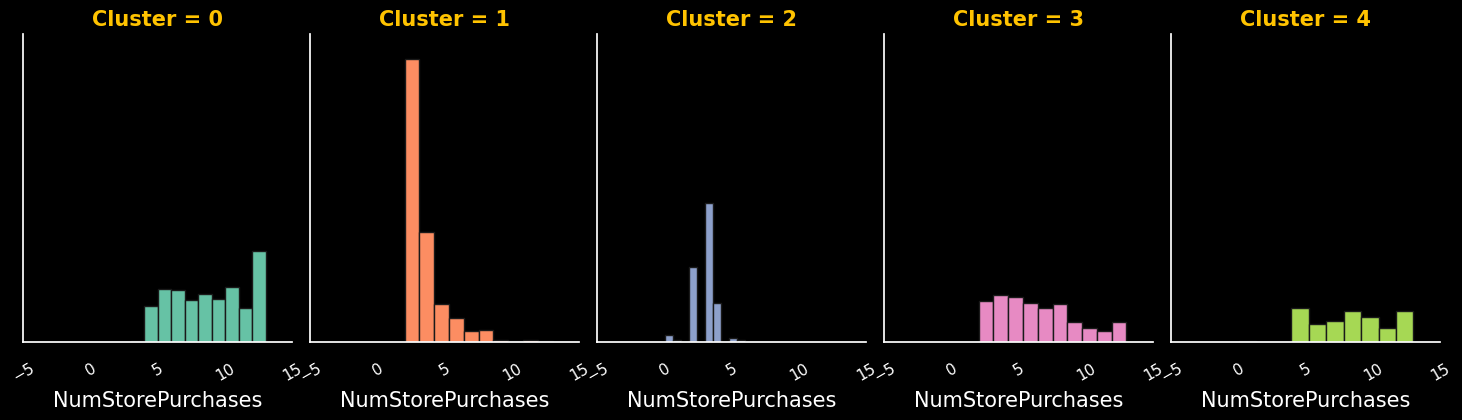

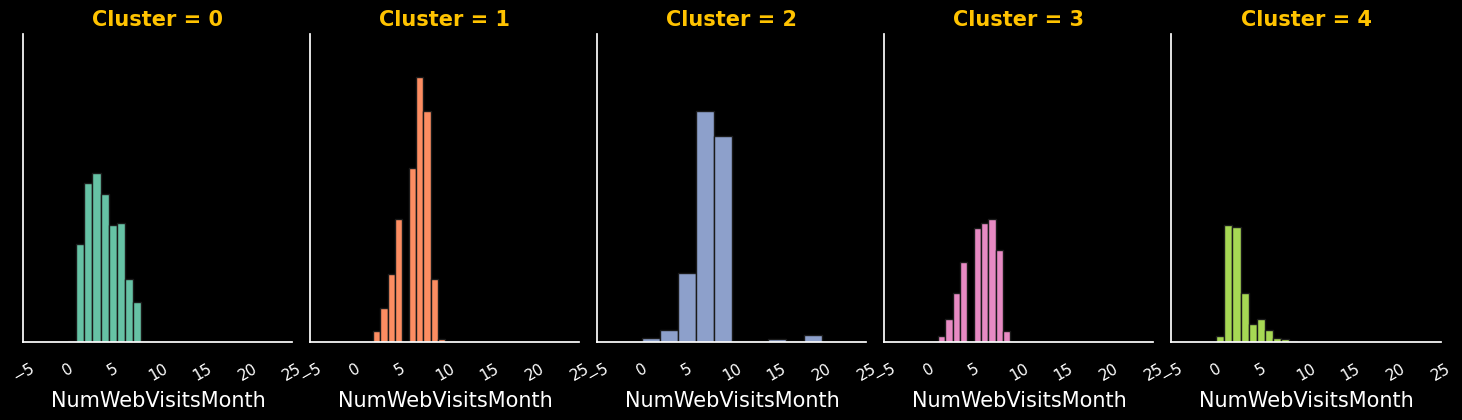

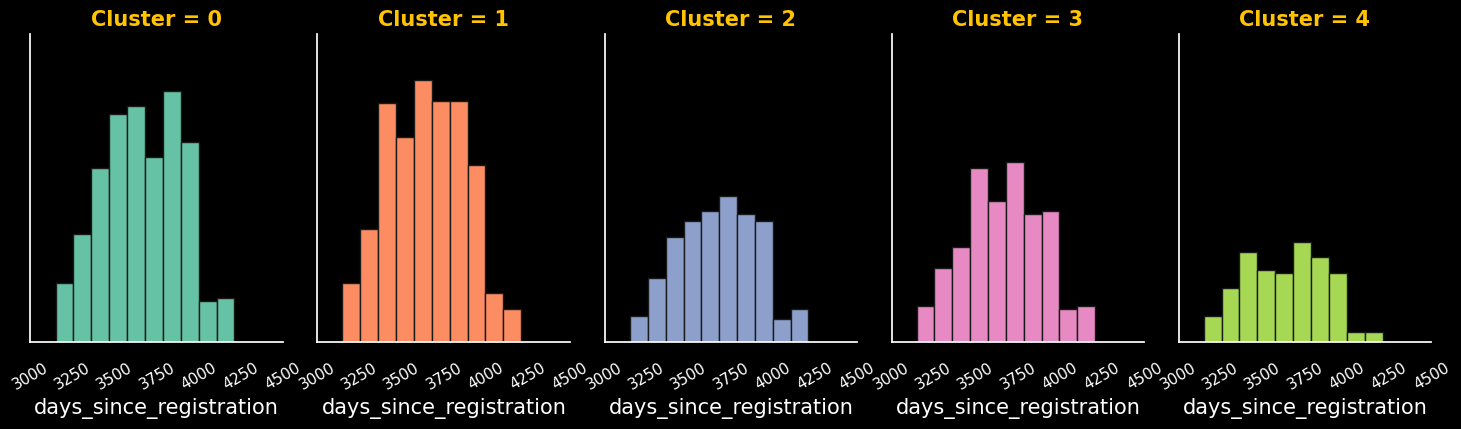

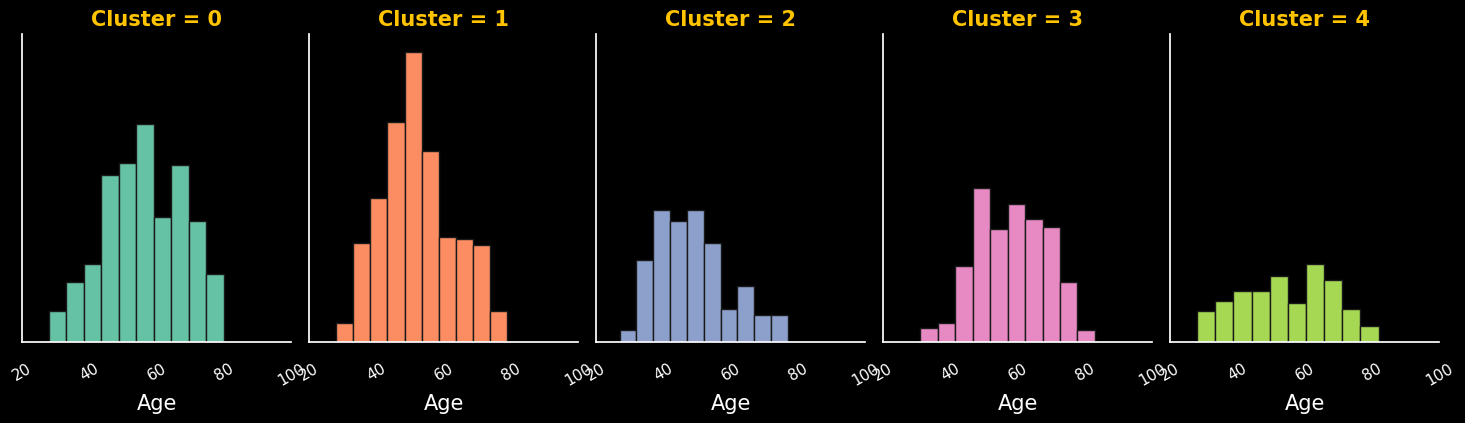

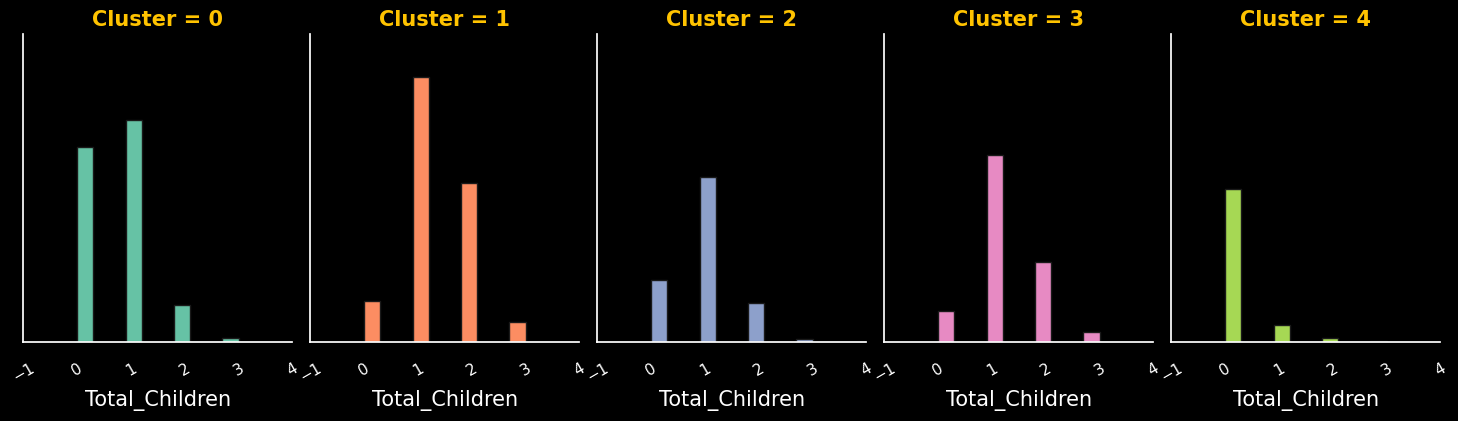

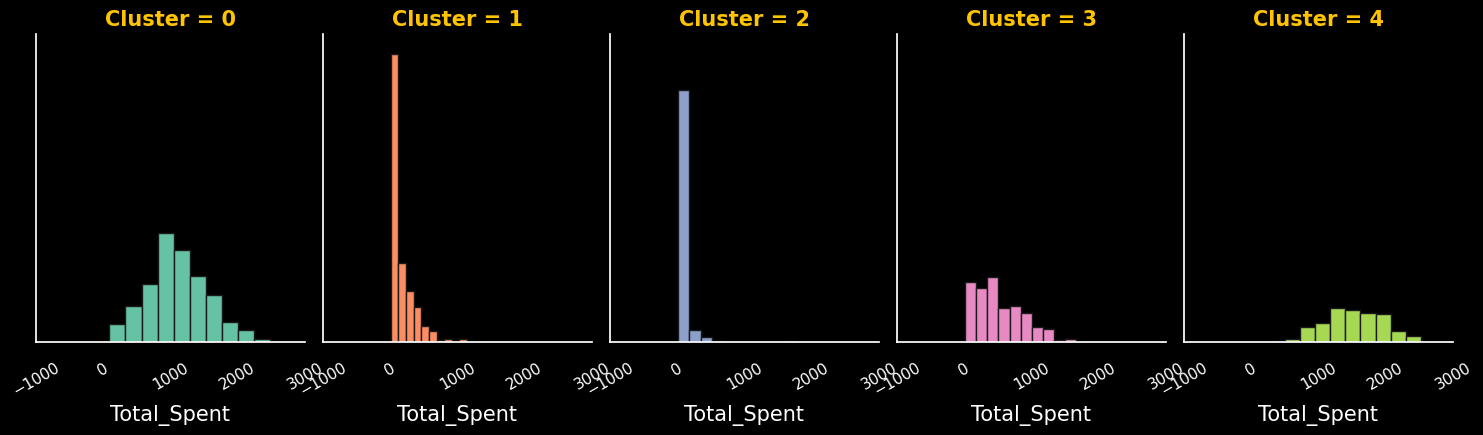

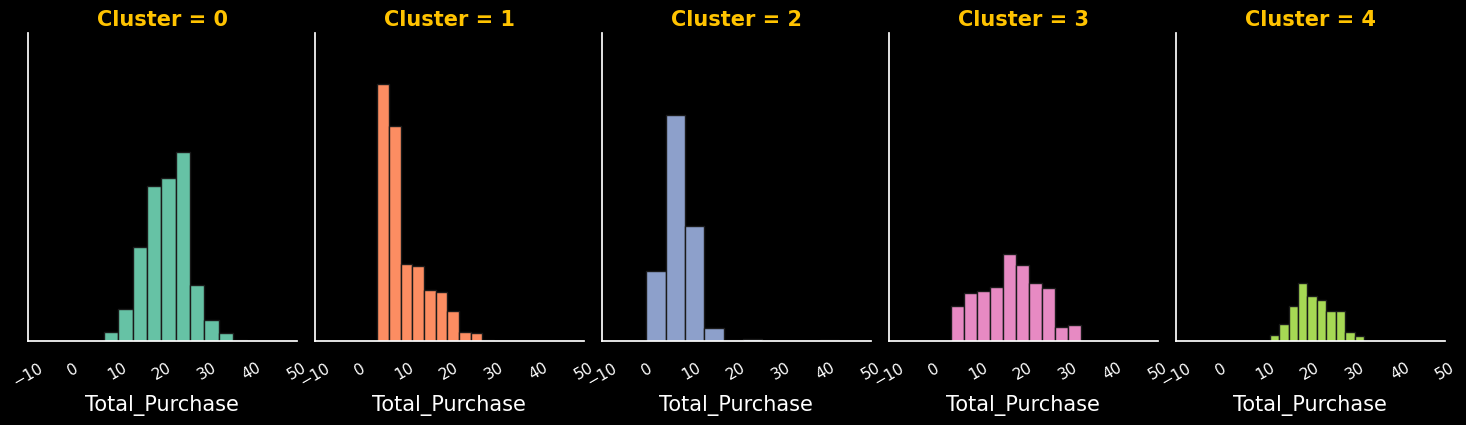

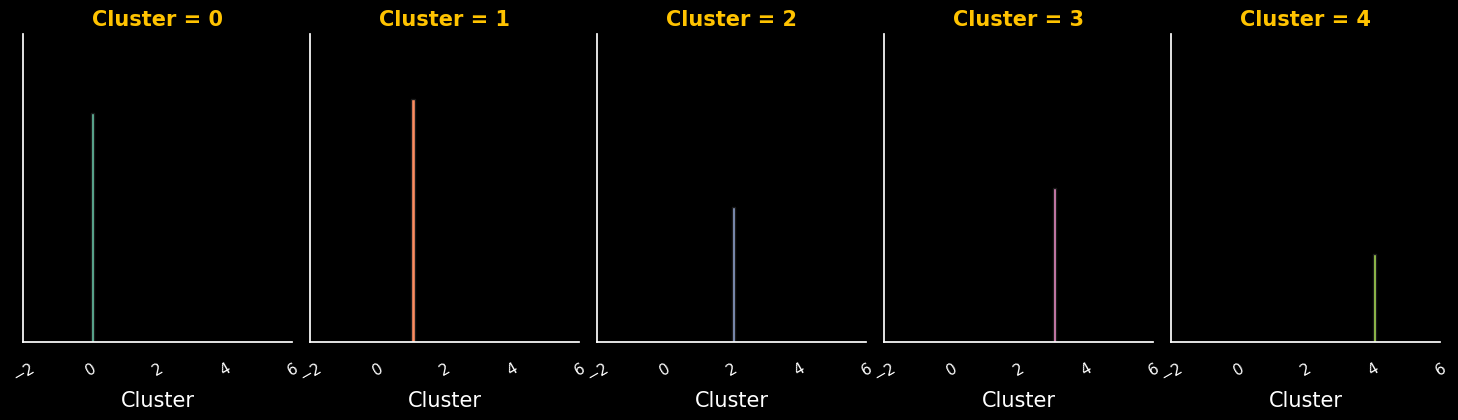

In [42]:
# Clusters interpretation birch
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'font.family': 'Ubuntu'})

for i in df:
    g = sns.FacetGrid(df, col = "Cluster", hue = "Cluster", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=30, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)

### **Penjelasan Hasil Clustering Birch**
**Cluster 0:**
- Income menengah atas
- Suka membeli banyak barang
- Suka membeli barang mahal
- Suka membeli wine dan daging

**Cluster 1:**
- Income menengah bawah
- Jarang membeli barang
- Mayoritas memiliki anak

**Cluster 2:**
- Income rendah
- Paling jarang membeli barang
- Mayoritas orang berusia muda
- Hampir tidak pernah membeli produk via katalog

**Cluster 3:**
- Income menengah
- Suka membeli banyak barang
- Suka membeli barang murah
- Suka membeli barang ketika ada diskon

**Cluster 4:**
- Income tinggi
- Menghabiskan banyak uang ketike berbelanja
- Suka membeli berbagai jenis produk
- Hampir semuanya tidak memiliki anak
- Tidak menunggu diskon ketika membeli barang

### **Test Prediction using KMeans**

In [43]:
with open('models/kmeans.pickle', 'rb') as f:
    model = pickle.load(f)

In [45]:
inputan = np.array([0,1,100000,30,1300,588,1000,500,533,1000,1,9,7,8,3,4000,50,0,2500,25])

In [46]:
cluster = model.predict([inputan])
print('Customer cluster =', cluster[0])

Customer cluster = 3


c:\Users\Nando\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
